This [Colab](https://research.google.com/colaboratory/faq.html) notebook is meant to be used as a quick demonstration of DeLTA's 
capabilities. Use of Google Colab is free, but Google might kill your process if
you use too many resources. We offer 3 approaches to run evaluations for movies 
that we have made available with our software, but you can copy and modify this 
notebook to run on your own data. If you would like to know more check out our
Gitlab repository:

https://gitlab.com/dunloplab/delta

⚠ Important ⚠

Before you get started, make sure you run this notebook with a GPU:
```
Menu > Runtime > Change runtime type
```

# Installation and setup

> *For each code cell below, you will need to run it by clicking the play button (you also can collapse this whole installation section with the down arrow on the left and run it all as one big cell)*


First, download the code and install the environment. Here we are going to do it through pip and use the sources from gitlab because conda takes a very long time to resolve the environment in Colab for some reason:

In [ ]:
!git clone https://gitlab.com/dunloplab/delta.git

!pip install -r delta/requirements.txt
!pip install python-bioformats



     |████████████████████████████████| 40.3 MB 1.3 MB/s 
     |████████████████████████████████| 1.3 MB 52.0 MB/s 
     |████████████████████████████████| 829 kB 51.8 MB/s 
     |████████████████████████████████| 132 kB 66.5 MB/s 
     |████████████████████████████████| 9.1 MB 60.1 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 140 kB 75.5 MB/s 
  Created wheel for python-javabridge: filename=python_javabridge-4.0.3-cp37-cp37m-linux_x86_64.whl size=1628150 sha256=5f2c210b2989c10275e64f37995dcf773efe5145e223b3749f6e128d6d7b6861
  Stored in directory: /root/.cache/pip/wheels/63/7e/91/01b1bd8d29b4323834feb5cfec49b857fb212e6efc74ce103c
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=d0af48f2bcddee6ca2256554de3e6fffe9086b59fde9e4cb7869e66e9a0ba374
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built python-javabridge future
 

In [ ]:

import sys
sys.path.append('/content/delta')

import delta


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/content/delta/delta/data.py:28: UserWarning: Could not load elastic deformations module.
  warnings.warn("Could not load elastic deformations module.")


In [ ]:
delta.assets.download_assets(
    load_models=True,
    load_sets=False,
    load_evals=False,
    config_level='global'
)

Models will be downloaded to /content/delta/delta/assets/models
Config files written to /content/delta/delta/assets/config


mount personal Google Drive


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive2/', force_remount=True)

# To download files to your local drive:
from google.colab.files import download as colab_download
from google.colab.files import upload as colab_upload

# To display resuults movies:
from IPython.display import HTML
from base64 import b64encode

def display_movie(filename):
  mp4 = open(filename,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=600 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url
  )

Mounted at /content/gdrive2/


## WT colony in presence of gentamicin 

### Load colony

In [ ]:

delta.config.load_config(presets='2D')

#these two lines might fix tracking issues: (only when actually running the pipeline)
delta.config.drift_correction = True
delta.config.whole_frame_drift = True

# # '/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_unzipped',
#  # resfolder='/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_eval_movie2/'

reader = delta.utilities.xpreader(
   '/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/WT_gm_RepBio1_RepT2_tl/unzipped',
    # prototype='Position%01d_Channel%01d_Frame%00002d.tif',
)

processor = delta.pipeline.Pipeline(
    reader,
    resfolder='/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/WT_gm_RepBio1_RepT2_tl/eval_movie',
    reload=True
    )

In [ ]:
# Select all the cells that are in frames 0-23, because in frame 23 the cells have good colonies


lin = processor.positions[0].rois[0].lineage
chopped = lin.cellnumbers[0:23]

chopped_all =[]

for list in chopped: 
  for item in list: 
    chopped_all.append(item)
 
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    
    return unique_list 

chopped_unique = unique(chopped_all)
    

In [ ]:
# Finding all of the cells that originated from a given mother cell 

def get_colony(mother_id):
  colony = []
  for cell in lin.cells:
    if cell['mother'] == mother_id or cell['mother'] in colony:
      colony.append(cell['id'])  

  return colony



In [ ]:
colony_clean =[]

for cnb in colony: 
  cell = lin.cells[cnb]
  if max(cell['length']) > 55 and min(cell['length']) < 35:
    colony_clean.append(cell['id'])



In [ ]:
import matplotlib.pyplot as plt

colony = get_colony(3)

for cnb in colony_clean: 
  cell = lin.cells[cnb]
  plt.plot(cell['frames'],cell['length'])
# for cell in lin.cells: 
#     plt.plot(cell['frames'],cell['length'])

plt.xlabel('frame #')
plt.ylabel('length (pixels)')
plt.show()

In [ ]:
# code to calculate crowdedness during a division event 
import math

def get_centre(npole, opole):
  cell_centre = ((npole[0] + opole[0])/2 ,  (npole[1] + opole[1])/2)
  return cell_centre

def get_cell_dist(centre1, centre2):
  # dist = ((centre1[0] + centre2[0])/2 ,  (centre1[1] + centre2[1])/2)
  dist = math.sqrt(((centre2[0] - centre1[0])**2 + (centre2[1] - centre1[1])**2))
  return dist

def get_crowd_2(cell_dist, cell_length):
  crowd = math.e**(((-cell_dist)/cell_length))
  return crowd

  

In [ ]:
def crowdedness_col(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  
  # total crowdedness at a given timepoint, given by frame number 
  total_crowdedness = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  for cnb in colony: 
    cell = lin.cells[cnb]
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    crowdedness = 0 #assign crowdedness to zero initially 
    crowd_ids.append(cell['id'])
    # print(cell['id'])
    # print(daughters)
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        frame_no = cell['frames'][idx]
        if frame_no < 23: 
          npole1 = cell['new_pole'][idx]
          opole1 = cell['old_pole'][idx]
          # get centre of cell 1 for distance function 
          cell1_centre = get_centre(npole1, opole1) 
          cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
          cell_div_length = cell['length'][idx]
          division_lengths.append(cell_div_length)
          daughter_index = daughters.index(daughter)
          if len(daughters) > 1 and daughter_index > 0:
            prev_daughter = daughters[daughter_index-1]
            # print(daughter, prev_daughter)
            div_cycle = frame_no - cell['frames'][prev_daughter]
          else:
            div_cycle = frame_no - cell['frames'][0]
          # print('div_cycle',div_cycle)
          div_cycle_lengths.append(div_cycle)
          for cnb2 in colony:
            cell2 = lin.cells[cnb2]
            if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
              idx2 = cell2['frames'].index(frame_no)
              npole2 = cell2['new_pole'][idx2]
              opole2 = cell2['old_pole'][idx2]
              cell2_centre = get_centre(npole2, opole2)
              # get distance between the two centre points 
              cell_dist = get_cell_dist(cell1_centre, cell2_centre)
              crowd_pair = get_crowd_2(cell_dist, cell1_length)
              crowdedness = crowdedness + crowd_pair 
              # conditions for calculating cell cycle are different, depending if there is only one div or more
          # print(crowdedness)
          total_crowdedness.append(crowdedness)

  plot = plt.scatter(total_crowdedness, div_cycle_lengths)
  plt.xlabel('Crowdedness at division time')
  plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  return  division_lengths



division_lengths = crowdedness_col(colony)


In [ ]:
  import seaborn as sns
  import statistics
  
  ax1 = sns.histplot(division_lengths, bins=30, stat='density', alpha= 1, kde=True,
                      edgecolor='white', linewidth=0.5,
                      line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
  ax1.get_lines()[0].set_color('black')
  mn = statistics.mean(division_lengths)
  sd = statistics.stdev(division_lengths)

  

In [ ]:
def crowdedness_col(population):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  total_crowdedness = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  for cell in population: 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    crowdedness = 0 #assign crowdedness to zero initially 
    crowd_ids.append(cell['id'])
    # print(cell['id'])
    # print(daughters)
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        frame_no = cell['frames'][idx]
        if frame_no < 23: 
          npole1 = cell['new_pole'][idx]
          opole1 = cell['old_pole'][idx]
          # get centre of cell 1 for distance function 
          cell1_centre = get_centre(npole1, opole1) 
          cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
          cell_div_length = cell['length'][idx]
          division_lengths.append(cell_div_length)
          daughter_index = daughters.index(daughter)
          if len(daughters) > 1 and daughter_index > 0:
            prev_daughter = daughters[daughter_index-1]
            # print(daughter, prev_daughter)
            div_cycle = frame_no - cell['frames'][prev_daughter]
          else:
            div_cycle = frame_no - cell['frames'][0]
          # print('div_cycle',div_cycle)
          div_cycle_lengths.append(div_cycle)
          for cell2 in population: 
            if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
              idx2 = cell2['frames'].index(frame_no)
              npole2 = cell2['new_pole'][idx2]
              opole2 = cell2['old_pole'][idx2]
              cell2_centre = get_centre(npole2, opole2)
              # get distance between the two centre points 
              cell_dist = get_cell_dist(cell1_centre, cell2_centre)
              crowd_pair = get_crowd_2(cell_dist, cell1_length)
              crowdedness = crowdedness + crowd_pair 
              # conditions for calculating cell cycle are different, depending if there is only one div or more
          # print(crowdedness)
          total_crowdedness.append(crowdedness)

  plot = plt.scatter(total_crowdedness,div_cycle_lengths )
  plt.xlabel('Crowdedness at division time')
  plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  return division_lengths 



division_lengths = crowdedness_col(lin.cells)

In [ ]:
import seaborn as sns
import statistics
  
ax1 = sns.histplot(division_lengths, bins=30, stat='density', alpha= 1, kde=True,
                    edgecolor='white', linewidth=0.5,
                    line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
ax1.get_lines()[0].set_color('black')
mn = statistics.mean(division_lengths)
sd = statistics.stdev(division_lengths)

print('Mean Division length' ,  mn , 'pixels')
print('Standard deviation' , sd )

In [ ]:
initial_lengths = []
for cell in lin.cells: 
  cell1_length =  min(cell['length'])
  initial_lengths.append(cell1_length)

ax1 = sns.histplot(initial_lengths, bins=30, stat='density', alpha= 1, kde=True,
                    edgecolor='white', linewidth=0.5,
                    line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
ax1.get_lines()[0].set_color('black')
mn = statistics.mean(initial_lengths)
sd = statistics.stdev(initial_lengths)

print('Cell initial length' ,  mn , 'pixels')
print('Standard deviation' , sd )

### Plotting to understand distribution

In [ ]:

def which_first(lineage, cell_nb, first_cells):

    # Get cell dict:
    cell = lineage.cells[cell_nb]

    # If orphan or reached one of the first two cells:
    if cell['mother'] is None or cell['mother'] in first_cells:
        return cell['mother']

    # Otherwise go up the lineage tree:
    else:
        return which_first(lineage, cell['mother'], first_cells)


import numpy as np

# Last labels frame:
labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# Go over cells in last frame:
for cnb in lin.cellnumbers[-1]:

    # Which initial cell is ancestor?
    ancestor = which_first(lin, cnb, first_cells)

    # Pick color based on ancestor:
    if ancestor is None:
        if cnb==0:
            color=[255,0,0]
        elif cnb==1:
            color=[0,0,255]
        else:
            color=[0,0,0]
    elif ancestor==0:
        color=[200,60,60]
    elif ancestor==1:
        color=[60,60,200]

    # Color in the cell:
    for c, val in enumerate(color):
        color_image[:,:,c][labels==cnb+1]=val

plt.imshow(color_image)
plt.show()


                             


## WT in the absence of gentamicin 


In [ ]:
% cd gdrive2
% cd MyDrive 
% cd Delta2Runs
% cd WT_Nogm_RepBio1_RepT2_tl
% ls

UsageError: Line magic function `%` not found.


### Load colony 

In [ ]:

delta.config.load_config(presets='2D')

#these two lines might fix tracking issues: (only when actually running the pipeline)
delta.config.drift_correction = True
delta.config.whole_frame_drift = True

# # '/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_unzipped',
#  # resfolder='/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_eval_movie2/'

reader = delta.utilities.xpreader(
   '/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/WT_Nogm_RepBio1_RepT1_tl/unzipped',
    # prototype='Position%01d_Channel%01d_Frame%00002d.tif',
)

processor = delta.pipeline.Pipeline(
    reader,
    resfolder='/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/WT_Nogm_RepBio1_RepT1_tl/eval_movie',
    reload=True
    )

Loading configuration from: /content/delta/delta/assets/config/config_2D.json


### Initialise functions needed for all downstream analysis 

In [ ]:
# code to calculate crowdedness during a division event 
import math
import numpy as np

def get_colony(cells, mother_id):
  colony = []
  colony.append(mother_id)
  for cell in lin.cells:
    if cell['mother'] == mother_id or cell['mother'] in colony:
      colony.append(cell['id'])
                    
  return colony 


def get_centre(npole, opole): # get cell centre, using the coordinates between two poles of the cell 
  cell_centre = ((npole[0] + opole[0])/2 ,  (npole[1] + opole[1])/2)
  return cell_centre

def get_cell_dist(centre1, centre2): # get the distance between two cell centres 
  # dist = ((centre1[0] + centre2[0])/2 ,  (centre1[1] + centre2[1])/2)
  dist = math.sqrt(((centre1[0] - centre2[0])**2 + (centre1[1] - centre2[1])**2))
  return dist

def get_crowd_2(cell_dist, cell_length):
  crowd = math.e**((-cell_dist/cell_length))
  return crowd

# not useful - use centre 
def is_neighbour(centre1, c2_opole, c2_npole, cell1_l0):
  dist_opole = math.sqrt(((centre1[0] - c2_opole[0])**2 + (centre1[1] - c2_opole[1])**2))
  dist_npole = math.sqrt(((centre1[0] - c2_npole[0])**2 + (centre1[1] - c2_npole[1])**2))
  if dist_opole < 2*cell1_l0 or dist_npole < 2*cell1_l0: 
    return True 
  else: 
    return False 

def is_in_radius(centre1,cell1_l0,c2_opole, c2_npole): 
  radius = 30 * 1.5
  if ((c2_opole[0] - centre1[0])**2 + ((c2_opole[1] - centre1[1])**2) < radius **2) or  ((c2_npole[0] - centre1[0])**2 + ((c2_npole[1] - centre1[1])**2) < radius **2):
    return True 
  else: 
    return False
  
def get_length_alt(npole, opole):
  cell_length = math.sqrt((opole[0]- npole[0])**2 + (opole[1]- npole[1])**2)
  return cell_length

def get_poleside(centre1, opole1, npole1, npole2, opole2, cell1_length, cell1_width):
  # substracting the coordinates of the centre of cell1 ( the cell in question) from the poles of all cells 
  # After this, the centre of cell 1 lies at 0,0 
  opole1_new = [opole1[0] - centre1[0], opole1[1] - centre1[1]]
  npole1_new = [npole1[0] - centre1[0] , npole1[1] - centre1[1]]
  npole2_new = [npole2[0] - centre1[0] , npole2[1] - centre1[1]]
  opole2_new = [opole2[0] - centre1[0] , opole2[1] - centre1[1]]
  # tan theta for cell 1: y(npole)- y(opole) / x(npole) -x(opole)
  # opole and npole is just delta nomenclature for the 2 poles 
  tantheta = (opole1[1]- npole1[1]) / (opole1[0]- npole1[0])
  # using arctan to get theta 
  theta = math.atan(tantheta)
  #  creating a rotation matrix, rot using the theta obtained 
  rot = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
  # multiplying each coordinate by rotation matrix to perform rotation
  opole1_rot = np.dot(rot, opole1_new)
  npole1_rot = np.dot(rot, npole1_new)
  opole2_rot = np.dot(rot, opole2_new)    
  npole2_rot = np.dot(rot, npole2_new)
  # now for each pole of cell 2 : 
  # first checking that the x coordinate lies within the length of cell 1 
  if abs(npole2_rot[0]) < cell1_length:
    # if that is the case, checking that the y coordinate is within 2w of cell1 
    if  abs(npole2_rot[1]) < 2*cell1_width:
      return True 
  elif abs(opole2_rot[0]) < cell1_length:
    if  abs(opole2_rot[1]) < 2*cell1_width:
      return True

# flipping the turn function in order to count the pole to side contacts but in the frame of cell 1 
def get_poleside_flipped(centre2, opole1, npole1, npole2, opole2, cell2_length, cell2_width):
  # substracting the coordinates of the centre of cell1 ( the cell in question) from the poles of all cells 
  # After this, the centre of cell 1 lies at 0,0 
  opole1_new = [opole1[0] - centre2[0], opole1[1] - centre2[1]]
  npole1_new = [npole1[0] - centre2[0] , npole1[1] - centre2[1]]
  npole2_new = [npole2[0] - centre2[0] , npole2[1] - centre2[1]]
  opole2_new = [opole2[0] - centre2[0] , opole2[1] - centre2[1]]
  # tan theta for cell 1: y(npole)- y(opole) / x(npole) -x(opole)
  # opole and npole is just delta nomenclature for the 2 poles 
  tantheta = (opole2[1]- npole2[1]) / (opole2[0]- npole2[0])
  # using arctan to get theta 
  theta = math.atan(tantheta)
  #  creating a rotation matrix, rot using the theta obtained 
  rot = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
  # multiplying each coordinate by rotation matrix to perform rotation
  opole1_rot = np.dot(rot, opole1_new)
  npole1_rot = np.dot(rot, npole1_new)
  opole2_rot = np.dot(rot, opole2_new)    
  npole2_rot = np.dot(rot, npole2_new)
  # now for each pole of cell 2 : 
  # first checking that the x coordinate lies within the length of cell 1 
  if abs(npole1_rot[0]) < cell2_length:
    # if that is the case, checking that the y coordinate is within 2w of cell1 
    if  abs(npole1_rot[1]) < 2*cell2_width:
      return True 
  elif abs(opole1_rot[0]) < cell2_length:
    if  abs(opole1_rot[1]) < 2*cell2_width:
      return True
 
 #Colony refinement 
def refine_colony(colony):
  for cnb in colony: 
    cell = lin.cells[cnb]
    npole1 = cell['new_pole'][-1]
    opole1 = cell['old_pole'][-1]
    # get centre of cell 1 for distance function 
    cell1_centre = get_centre(npole1, opole1)
    cell1_length = get_length_alt(npole1, opole1)
    cell1_width = cell['width'][0]
    neighbours = 0
    for cnb2 in lin.cellnumbers[-1]:
      if cnb2 not in colony: 
        cell2 = lin.cells[cnb2]
        npole2 = cell2['new_pole'][-1]
        opole2 = cell2['old_pole'][-1]
        cell2_centre = get_centre(npole2, opole2)
        cell2_length = cell2['length'][0]
        cell2_width = cell2['width'][0]
      if (get_cell_dist(opole1, npole2) < (2*cell1_width)) or (get_cell_dist(opole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, npole2) < (2*cell1_width)): 
        if cnb2 not in colony: 
          colony.append(cnb2)
      
  return(colony)

  


### Get population length distribution

In [ ]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib import rc
import statistics as stat
from matplotlib.pyplot import figure

lin = processor.positions[0].rois[0].lineage

first_cells = lin.cellnumbers[0]

pop_div_lengths = []
div_frames = []
pop_birth_lengths = []

for cnb  in colony_1011:
  cell = lin.cells[cnb]
  daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
  for daughter in daughters: 
    if daughters.index(daughter) == 0: 
      div_len_idx = daughter - 1 
      div_length = cell['length'][div_len_idx] 
      div_frame = cell['frames'][div_len_idx] 
      pop_div_lengths.append(div_length)
      pop_birth_lengths.append(cell['length'][0])
      div_frames.append(div_frame)
    
        




plt.figure(figsize=(7,7))
plt.scatter(div_frames,pop_div_lengths)
plt.xlabel('Division frame', fontname = 'STIXGeneral', fontsize=20)
plt.ylabel('Division length (pixels)', fontname = 'STIXGeneral',  fontsize=20)
# plt.title('Division length in WT P.aureginosa as a function of division frame')
plt.title('Division length in WT P.aureginosa as a function of division frame',fontname = 'STIXGeneral', fontsize=20, pad =20)
plt.xticks(fontname = 'STIXGeneral', fontsize=20)
plt.yticks(fontname = 'STIXGeneral', fontsize=20)
figure(figsize=(20,16))
plt.show()




NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ValueError: ignored

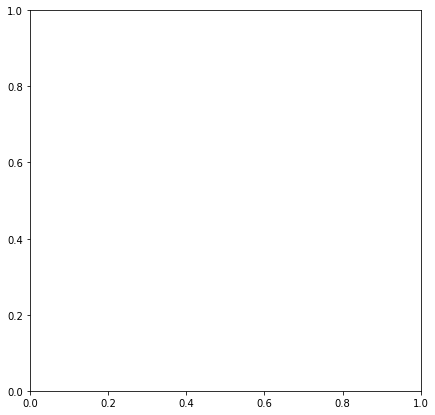

In [ ]:
import statistics as stats 

plt.figure(figsize=(7,7))
ax = sns.distplot(pop_div_lengths, hist=True, kde=True, 
             bins=int(len(pop_div_lengths)/50), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Density', fontname = 'STIXGeneral', fontsize = 23)
ax.set_xlabel('Division length (pixels)', fontname = 'STIXGeneral', fontsize = 23)
ax.set_title ('Division length distribution in WT P.aureginosa cells', fontname = 'STIXGeneral', fontsize = 23, pad = 20)
# ax.set_xticklabels(fontname = 'STIXGeneral', fontsize=20)
# ax.set_yticks(fontname = 'STIXGeneral', fontsize=20)
ylabels = plt.yticks(fontname = 'STIXGeneral', fontsize=22)
xlabels = plt.xticks(fontname = 'STIXGeneral', fontsize=22)
plt.show()

print(stats.mean(pop_div_lengths), stats.stdev(pop_div_lengths))




In [ ]:
plt.scatter(pop_birth_lengths, pop_div_lengths)

{'id': 0, 'mother': None, 'frames': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'daughters': [None, None, 61, None, None, None, 114, None, None, None, 248, None, None], 'new_pole': [array([  37, 1920], dtype=int16), array([  40, 1917], dtype=int16), array([  26, 1938], dtype=int16), array([  39, 1937], dtype=int16), array([  42, 1936], dtype=int16), array([  51, 1934], dtype=int16), array([  24, 1943], dtype=int16), array([  22, 1941], dtype=int16), array([  23, 1953], dtype=int16), array([  33, 1956], dtype=int16), array([   9, 1957], dtype=int16), array([  10, 1960], dtype=int16), array([   9, 1966], dtype=int16)], 'old_pole': [array([  25, 1942], dtype=int16), array([  21, 1949], dtype=int16), array([  22, 1949], dtype=int16), array([  22, 1942], dtype=int16), array([  20, 1943], dtype=int16), array([  14, 1945], dtype=int16), array([  13, 1945], dtype=int16), array([   7, 1951], dtype=int16), array([  10, 1950], dtype=int16), array([   4, 1953], dtype=int16), array([   9, 1958], dt

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


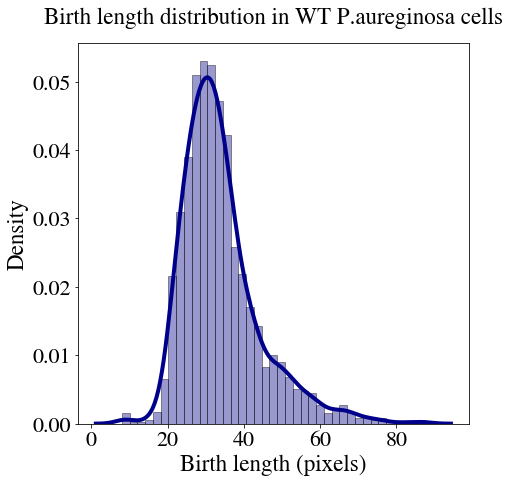

33.98519493247494 10.315388369940266


In [ ]:
first_cells = lin.cells[0]
print(first_cells)

pop_birth_lengths=[]
for cell in lin.cells: 
  if cell['id'] in first_cells or cell['mother'] is not None: 
    birth_length = cell['length'][0]
    pop_birth_lengths.append(birth_length)


plt.figure(figsize=(7,7))
ax2 = sns.distplot(pop_birth_lengths, hist=True, kde=True, 
             bins=int(len(pop_birth_lengths)/50), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_ylabel('Density', fontname = 'STIXGeneral', fontsize = 23)
ax2.set_xlabel('Birth length (pixels)', fontname = 'STIXGeneral', fontsize = 23)
ax2.set_title ('Birth length distribution in WT P.aureginosa cells', fontname = 'STIXGeneral', fontsize = 23, pad = 20)
# ax.set_xticklabels(fontname = 'STIXGeneral', fontsize=20)
# ax.set_yticks(fontname = 'STIXGeneral', fontsize=20)
ylabels = plt.yticks(fontname = 'STIXGeneral', fontsize=22)
xlabels = plt.xticks(fontname = 'STIXGeneral', fontsize=22)
plt.show()

print(stats.mean(pop_birth_lengths), stats.stdev(pop_birth_lengths))

In [ ]:
#scaled lengths 

pop_scaled_mean = (stat.mean(pop_div_lengths)/ stat.mean(pop_birth_lengths))
pop_scaled_sd = (stat.stdev(pop_div_lengths)/ stat.stdev(pop_birth_lengths))


print(pop_scaled_mean, pop_scaled_sd )

1.4727683172869435 1.219282088707164


### Length of all cells vs frame

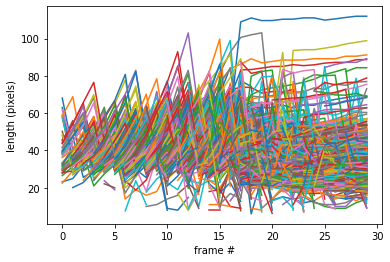

In [ ]:
lin = processor.positions[0].rois[0].lineage
first_cells = lin.cellnumbers[0]

import matplotlib.pyplot as plt

for cell in lin.cells: 
  plt.plot(cell['frames'],cell['length'])

plt.xlabel('frame #')
plt.ylabel('length (pixels)')
plt.show()



### Select one colony, look at lengths over lifetime (in frames) 

77


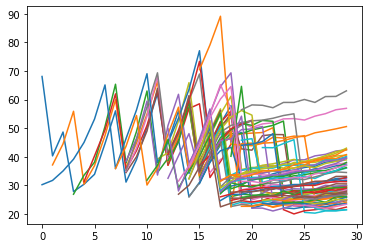

In [ ]:
# Finding all of the cells that originated from a given mother cell 
# mother_id = 7
# colony = []
# for cell in lin.cells:
#   if cell['mother'] == mother_id or cell['mother'] in colony:
#     colony.append(cell['id']) 

# print(len(colony)) 

colony_1011 =[]

colony_10 = get_colony(lin.cells, 10)
colony_11 = get_colony(lin.cells, 11)
colony_1011 = colony_10 + colony_11

for cnb in colony_1011: 
  cell = lin.cells[cnb]
  plt.plot(cell['frames'],cell['length'])

print(len(colony_1011))

77


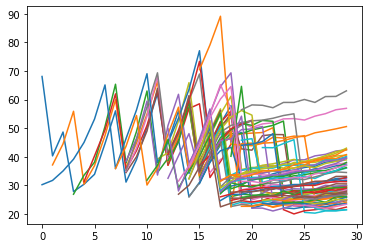

In [ ]:
# Finding all of the cells that originated from a given mother cell 
# mother_id = 7
# colony = []
# for cell in lin.cells:
#   if cell['mother'] == mother_id or cell['mother'] in colony:
#     colony.append(cell['id']) 

# print(len(colony)) 

colony_1011 =[]

colony_10 = get_colony(lin.cells, 10)
colony_11 = get_colony(lin.cells, 11)
colony_1011 = colony_10 + colony_11

for cnb in colony_1011: 
  cell = lin.cells[cnb]
  plt.plot(cell['frames'],cell['length'])

print(len(colony_1011))

55


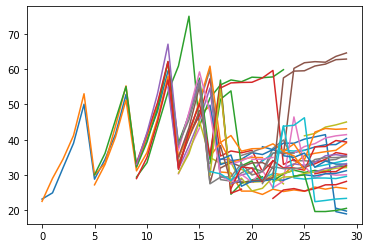

In [ ]:
# Finding all of the cells that originated from a given mother cell 
# mother_id = 7
# colony = []
# for cell in lin.cells:
#   if cell['mother'] == mother_id or cell['mother'] in colony:
#     colony.append(cell['id']) 

# print(len(colony)) 

colony_2021 =[]

colony_20 = get_colony(lin.cells, 20)
colony_21 = get_colony(lin.cells, 21)
colony_2021 = colony_20 + colony_21

for cnb in colony_2021: 
  cell = lin.cells[cnb]
  plt.plot(cell['frames'],cell['length'])

print(len(colony_2021))

### Do colony refinement using contacts 

In [ ]:
# plotting the crowdedness of each cell in the population at a given time (change the index of lin.cellnumbers) 
colony_1011_ref = refine_colony(colony_1011)

In [ ]:
colony_2021_ref = refine_colony(colony_2021)

(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]), <a list of 11 Text major ticklabel objects>)

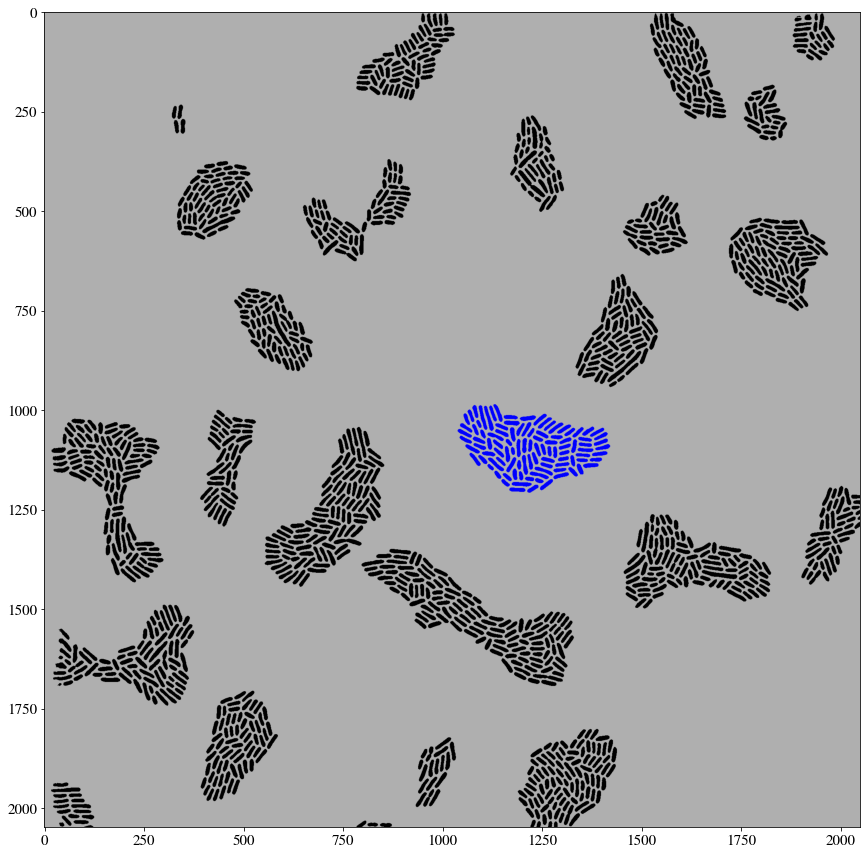

In [ ]:
# check that colony looks good 

import numpy as np


labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# colony1 = get_colony(lin.cells, 1)
# colony2 = get_colony(lin.cells, 2)

# colony = colony1 + colony2


# col_1011_cids, col_1011_neighbours, col_1011_cycles = numneighbours_immediate(colony_1011)

for cell in lin.cellnumbers[-1]:
  if cell in colony_2021_ref:
    color = [0,0,255]
  else: 
     color = [0,0,0]


  for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val
      



plt.figure(figsize = (15,15))
plt.imshow(color_image)
# plt.ylim(200, 1000)
# plt.xlim(1200, 2000)
plt.xticks(fontname = 'STIXGeneral', fontsize=15)
plt.yticks(fontname = 'STIXGeneral', fontsize=15)



### Get division length distribution in colony

In [ ]:
import seaborn as sns
import statistics as stat

col_div_lengths = []
for cnb in colony_1011_ref: 
  cell = lin.cells[cnb]
  daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
  for daughter in daughters: 
    div_len_idx = daughter - 1 
    div_length = cell['length'][div_len_idx]
    col_div_lengths.append(div_length)
  
## Plot histogram of division lengths (aka density distribution)

ax = sns.distplot(col_div_lengths, hist=True, kde=True, 
             bins=int(len(col_div_lengths)/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set(ylabel='Density', xlabel='Division length (pixels')
plt.show()

print(stat.mean(col_div_lengths), stat.stdev(col_div_lengths))

NameError: ignored

### Get birth length distribution in colony

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


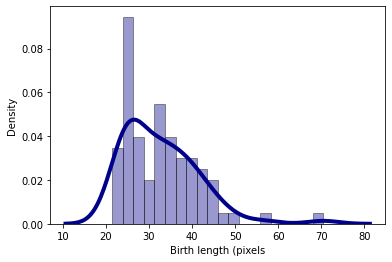

32.70822134250548 8.713382624856516


In [ ]:
import seaborn as sns
import statistics as stat


first_cells = lin.cellnumbers[0]

col_birth_lengths = []
for cnb in colony_1011_ref: 
  cell = lin.cells[cnb]
  if cell in first_cells or cell['mother'] is not None:
    birth_length = cell['length'][0]
    col_birth_lengths.append(birth_length)

## Plot histogram of birth lengths (aka density distribution)

ax = sns.distplot(col_birth_lengths, hist=True, kde=True, 
             bins=int(len(col_div_lengths)/4), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set(ylabel='Density', xlabel='Birth length (pixels')
plt.show()

print(stat.mean(col_birth_lengths), stat.stdev(col_birth_lengths))

In [ ]:
mean_scaled = stat.mean(col_div_lengths) / stat.mean(col_birth_lengths)
sd_scaled = stat.stdev(col_div_lengths) / stat.stdev(col_birth_lengths)


print('Scaled mean : ' + str(mean_scaled ) + ' ' + 'Scaled sd ' + str(sd_scaled)) 

Scaled mean : 1.7251551788603638 Scaled sd 1.1019258411369999


In [ ]:
from numpy.ma.extras import average
import pandas as pd
import seaborn as sns

def numneighbours_radial(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  # total_crowdedness = []

  nums_of_neighbours = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  print(len(colony))
  
  for cnb in colony: 
    cell = lin.cells[cnb]
    # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    # print(cell['id'])
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        # print(daughter, idx)
        frame_no = cell['frames'][idx]
        # print(frame_no)
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        # crowdness = 0
        neighbours = 0 
        cell1_width = cell['width'][0]
        npole_new = npole1 - cell1_centre
        for cell2 in lin.cells:
        # for cnb2 in colony:
        #   cell2 = lin.cells[cnb2]
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            # set cell poles 
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            cell2_centre = get_centre(npole2, opole2)
            cell2_width = cell2['width'][0]
            cell2_length = cell2['length'][0]

            if (get_cell_dist(opole1, npole2) < (1.5*cell1_width)) or (get_cell_dist(opole1, opole2) < (1.5*cell1_width)) or (get_cell_dist(npole1, opole2) < (1.5*cell1_width)) or (get_cell_dist(npole1, npole2) < (1.5*cell1_width)): 
            # # if (get_cell_dist(opole1, npole2) < (cell1_width)) or (get_cell_dist(opole1, opole2) < (cell1_width)) or (get_cell_dist(npole1, opole2) < (cell1_width)) or (get_cell_dist(npole1, npole2) < (cell1_width)): 
              neighbours = neighbours + 1
            # # elif get_poleside(cell1_centre, npole1, opole1, npole2, opole2, cell1_length, cell1_width) is True:
            # #   neighbours = neighbours + 1
            elif get_poleside_flipped(cell2_centre, opole1, npole1, npole2, opole2, cell2_length, cell2_width) is True:
              neighbours = neighbours + 1
            # conditions for calculating cell cycle are different, depending if there is only one div or more
            # if is_in_radius(cell1_centre ,cell1_length ,opole2, npole2): 
            #   neighbours = neighbours + 1


            # cell_dist = get_cell_dist(cell1_centre, cell2_centre)
            # crowd2 = get_crowd_2(cell_dist, cell1_length)
            # crowdness = crowdness + crowd2
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              # print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
            # print(neighbours)
      if div_cycle > 0:
        div_cycle_lengths.append(div_cycle)
        # nums_of_neighbours.append(neighbours)
        division_lengths.append(cell_div_length)
        crowd_ids.append(cell['id'])
        nums_of_neighbours.append(neighbours)


    #Plotting for length in relation to crowdedness 
    # print(crowd_ids, nums_of_neighbours,  div_cycle_lengths)
  print(max(nums_of_neighbours))
  d = {'neighbours':nums_of_neighbours,'division_cycle':div_cycle_lengths}
  df = pd.DataFrame(d)

  plt.figure(figsize=(9,5))
  ax = sns.boxplot(x = 'neighbours', y = 'division_cycle', data = df)
  # plt.scatter(nums_of_neighbours, div_cycle_lengths)
  plt.xlabel('Number of Pole Contacs', fontname = 'STIXGeneral', fontsize = 23)
  plt.ylabel('Division cycle length (frames)',  fontname = 'STIXGeneral', fontsize = 23)
  plt.title("Division cycle length vs Number of Pole Contacts", fontname = 'STIXGeneral', fontsize = 23, pad = 20)
  plt.xlim(-1 ,max(nums_of_neighbours))
  plt.ylim(-1 , max(div_cycle_lengths)+1)
  
  # ax.set_xticklabels(fontname = 'STIXGeneral', fontsize=20)
  # ax.set_yticks(fontname = 'STIXGeneral', fontsize=20)
  plt.yticks(fontname = 'STIXGeneral', fontsize=22)
  plt.xticks(fontname = 'STIXGeneral', fontsize=22)
  # theta = np.polyfit(nums_of_neighbours, div_cycle_lengths, 1)
  # y_line =[]
  # for i in range(len(nums_of_neighbours)): 
  #   y = theta[1] + theta[0] * i
  #   y_line.append(y)
  # plt.plot(y_line)


  # plt.legend([str(theta[0]) + 'x' + ','+ str(theta[1])], loc = 'best')



    # plt.xlabel('Crowdedness at division time')
    # plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  print(len(crowd_ids))
  # print(nums_of_neighbours)
  print(average(nums_of_neighbours))
  print(average(div_cycle_lengths))
  # print(div_cycle_lengths)
  print(len(colony))
  print(min(nums_of_neighbours))
  return crowd_ids, nums_of_neighbours, div_cycle_lengths



In [ ]:
from numpy.ma.extras import average
import pandas as pd
import seaborn as sns

def numneighbours_radial(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  # total_crowdedness = []

  nums_of_neighbours = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  print(len(colony))
  
  for cnb in colony: 
    cell = lin.cells[cnb]
    # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    # print(cell['id'])
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        # print(daughter, idx)
        frame_no = cell['frames'][idx]
        # print(frame_no)
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        # crowdness = 0
        neighbours = 0 
        cell1_width = cell['width'][0]
        npole_new = npole1 - cell1_centre
        for cell2 in lin.cells:
        # for cnb2 in colony:
        #   cell2 = lin.cells[cnb2]
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            # set cell poles 
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            cell2_centre = get_centre(npole2, opole2)
            cell2_width = cell2['width'][0]
            cell2_length = cell2['length'][0]

            # if (get_cell_dist(opole1, npole2) < (1.5*cell1_width)) or (get_cell_dist(opole1, opole2) < (1.5*cell1_width)) or (get_cell_dist(npole1, opole2) < (1.5*cell1_width)) or (get_cell_dist(npole1, npole2) < (1.5*cell1_width)): 
            # # if (get_cell_dist(opole1, npole2) < (cell1_width)) or (get_cell_dist(opole1, opole2) < (cell1_width)) or (get_cell_dist(npole1, opole2) < (cell1_width)) or (get_cell_dist(npole1, npole2) < (cell1_width)): 
            #   neighbours = neighbours + 1
            # # elif get_poleside(cell1_centre, npole1, opole1, npole2, opole2, cell1_length, cell1_width) is True:
            # #   neighbours = neighbours + 1
            # elif get_poleside_flipped(cell2_centre, opole1, npole1, npole2, opole2, cell2_length, cell2_width) is True:
            #   neighbours = neighbours + 1
            # conditions for calculating cell cycle are different, depending if there is only one div or more
            if is_in_radius(cell1_centre ,cell1_length ,opole2, npole2): 
              neighbours = neighbours + 1


            # cell_dist = get_cell_dist(cell1_centre, cell2_centre)
            # crowd2 = get_crowd_2(cell_dist, cell1_length)
            # crowdness = crowdness + crowd2
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              # print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
            # print(neighbours)
      if div_cycle > 0:
        div_cycle_lengths.append(div_cycle)
        # nums_of_neighbours.append(neighbours)
        division_lengths.append(cell_div_length)
        crowd_ids.append(cell['id'])
        nums_of_neighbours.append(neighbours)


    #Plotting for length in relation to crowdedness 
    # print(crowd_ids, nums_of_neighbours,  div_cycle_lengths)
  print(max(nums_of_neighbours))
  d = {'neighbours':nums_of_neighbours,'division_cycle':div_cycle_lengths}
  df = pd.DataFrame(d)

  plt.figure(figsize=(9,5))
  ax = sns.boxplot(x = 'neighbours', y = 'division_cycle', data = df)
  # plt.scatter(nums_of_neighbours, div_cycle_lengths)
  plt.xlabel('Number of neighbours', fontname = 'STIXGeneral', fontsize = 23)
  plt.ylabel('Division cycle length (frames)',  fontname = 'STIXGeneral', fontsize = 23)
  plt.title("Division cycle length vs Number of neighbours", fontname = 'STIXGeneral', fontsize = 23, pad = 20)
  plt.ylim(-1, max(div_cycle_lengths)+1)
  
  # ax.set_xticklabels(fontname = 'STIXGeneral', fontsize=20)
  # ax.set_yticks(fontname = 'STIXGeneral', fontsize=20)
  plt.yticks(fontname = 'STIXGeneral', fontsize=22)
  plt.xticks(fontname = 'STIXGeneral', fontsize=22)
  # theta = np.polyfit(nums_of_neighbours, div_cycle_lengths, 1)
  # y_line =[]
  # for i in range(len(nums_of_neighbours)): 
  #   y = theta[1] + theta[0] * i
  #   y_line.append(y)
  # plt.plot(y_line)


  # plt.legend([str(theta[0]) + 'x' + ','+ str(theta[1])], loc = 'best')



    # plt.xlabel('Crowdedness at division time')
    # plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  print(len(crowd_ids))
  # print(nums_of_neighbours)
  print(average(nums_of_neighbours))
  print(average(div_cycle_lengths))
  # print(div_cycle_lengths)
  print(len(colony))
  print(min(nums_of_neighbours))
  return crowd_ids, nums_of_neighbours, div_cycle_lengths



88
17
38
10.131578947368421
3.8421052631578947
88
4


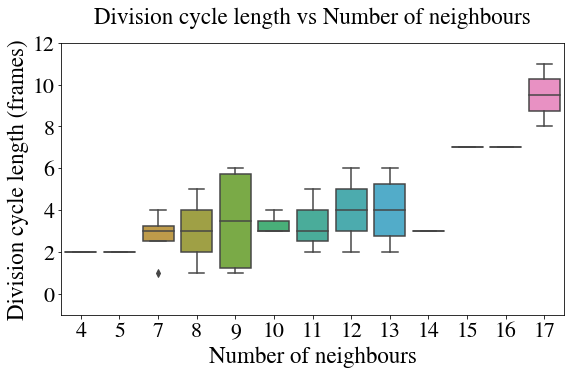

In [ ]:
crowd_ids, nums_of_neighbours, div_cycle_lengths = numneighbours_radial(colony_1011_ref)


In [ ]:
import numpy as np

import matplotlib.cm as cm 

import plotly.express as px

labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

col_1011_cids, col_1011_neighbours, col_1011_cycles = numneighbours_radial(colony_1011_ref)

for cell in lin.cellnumbers[-1]:
    if cell in col_1011_cids: 
      i = max(loc for loc, val in enumerate(col_1011_cids) if val == cell)
      c = cm.viridis((col_1011_neighbours[i])/max(col_1011_neighbours))
      color = c[0:3]
      # print(color)
    else: 
      color = [0,0,0]
    for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val*255

    
    
    


plt.figure(figsize = (15,15))
cax = plt.imshow(color_image)
# plt.pcolor(vmin=0, vmax=1)
plt.colorbar()
plt.clim(0,13)
plt.title('Whole population crowdedness plot for WT P.aureginosa')
plt.show()


NameError: ignored

In [ ]:
#  for entire population 



In [ ]:
from numpy.ma.extras import average

def neighbours_pp_ps(population):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  # total_crowdedness = []

  nums_of_neighbours = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]

  
  for cell in population: 
    # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    # print(cell['id'])
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        # print(daughter, idx)
        frame_no = cell['frames'][idx]
        # print(frame_no)
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        neighbours = 0
        cell1_width = cell['width'][0]
        npole_new = npole1 - cell1_centre
        for cell2 in lin.cells:
        # for cnb2 in colony:
        #   cell2 = lin.cells[cnb2]numneighbours_radialpop
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            # set cell poles 
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            cell2_centre = get_centre(npole2, opole2)
            cell2_width = cell2['width'][0]
            cell2_length = cell2['length'][0]
            # if (get_cell_dist(opole1, npole2) < (2*cell1_width)) or (get_cell_dist(opole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, npole2) < (2*cell1_width)): 
            if (get_cell_dist(opole1, npole2) < 2*(cell1_width)) or (get_cell_dist(opole1, opole2) < 2*(cell1_width)) or (get_cell_dist(npole1, opole2) < 2*(cell1_width)) or (get_cell_dist(npole1, npole2) < 2*(cell1_width)): 
              neighbours = neighbours + 1
            # elif get_poleside(cell1_centre, npole1, opole1, npole2, opole2, cell1_length, cell1_width) is True:
            #   neighbours = neighbours + 1
            elif get_poleside_flipped(cell2_centre, opole1, npole1, npole2, opole2, cell2_length, cell2_width) is True:
              neighbours = neighbours + 1
            # conditions for calculating cell cycle are different, depending if there is only one div or more
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              # print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
            # print(neighbours)
      if div_cycle > 0:
        div_cycle_lengths.append(div_cycle)
        nums_of_neighbours.append(neighbours)
        division_lengths.append(cell_div_length)
        crowd_ids.append(cell['id'])


    #Plotting for length in relation to crowdedness 
    # print(crowd_ids, nums_of_neighbours,  div_cycle_lengths)
  print(max(nums_of_neighbours))
  plt.scatter(nums_of_neighbours, div_cycle_lengths)
  plt.xlabel('Number of pole:pole or pole:side neighbours')
  plt.ylabel('Division cycle length')
  plt.title("Division length vs Number of neighbours for Wt colony of size 77 ")
  plt.xlim(0, max(nums_of_neighbours)+1)
  plt.ylim(0, max(div_cycle_lengths) +1)
  theta = np.polyfit(nums_of_neighbours, div_cycle_lengths, 1)
  y_line =[]
  for i in range(len(nums_of_neighbours)): 
    y = theta[1] + theta[0] * i
    y_line.append(y)
  plt.plot(y_line)
  plt.legend([str(theta[0]) + 'x' + ','+ str(theta[1])], loc = 'best')
  plt.figure(figsize = (15,20))
  print(theta)
    # plt.xlabel('Crowdedness at division time')
    # plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  print(len(crowd_ids))
  # print(nums_of_neighbours)
  print(average(nums_of_neighbours))
  print(average(div_cycle_lengths))
  # print(div_cycle_lengths)
  print(max(nums_of_neighbours))
  return crowd_ids, nums_of_neighbours, div_cycle_lengths


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in short_scalars


12
[0.03808367 3.23320177]
820
5.692682926829268
3.45
12


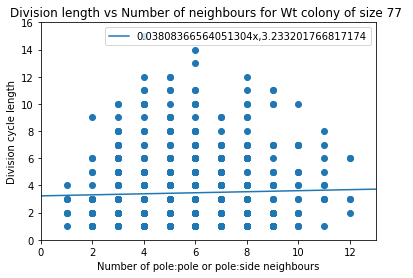

<Figure size 1080x1440 with 0 Axes>

In [ ]:
crowd_ids, nums_of_neighbours, div_cycle_lengths = neighbours_pp_ps(lin.cells) 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


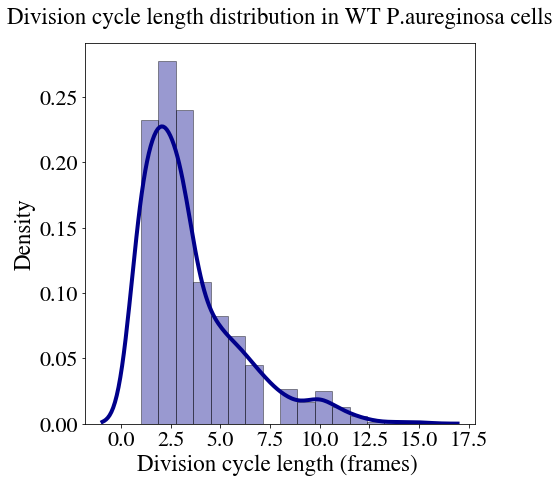

3.45 2.4740287126098743


In [ ]:
import statistics as stats 


plt.figure(figsize=(7,7))
ax2 = sns.distplot(div_cycle_lengths, hist=True, kde=True, 
             bins=int(len(div_cycle_lengths)/50), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_ylabel('Density', fontname = 'STIXGeneral', fontsize = 23)
ax2.set_xlabel('Division cycle length (frames) ', fontname = 'STIXGeneral', fontsize = 23)
ax2.set_title ('Division cycle length distribution in WT P.aureginosa cells', fontname = 'STIXGeneral', fontsize = 23, pad = 20)
# ax.set_xticklabels(fontname = 'STIXGeneral', fontsize=20)
# ax.set_yticks(fontname = 'STIXGeneral', fontsize=20)
ylabels = plt.yticks(fontname = 'STIXGeneral', fontsize=22)
xlabels = plt.xticks(fontname = 'STIXGeneral', fontsize=22)
plt.show()

print(stats.mean(div_cycle_lengths), stats.stdev(div_cycle_lengths))

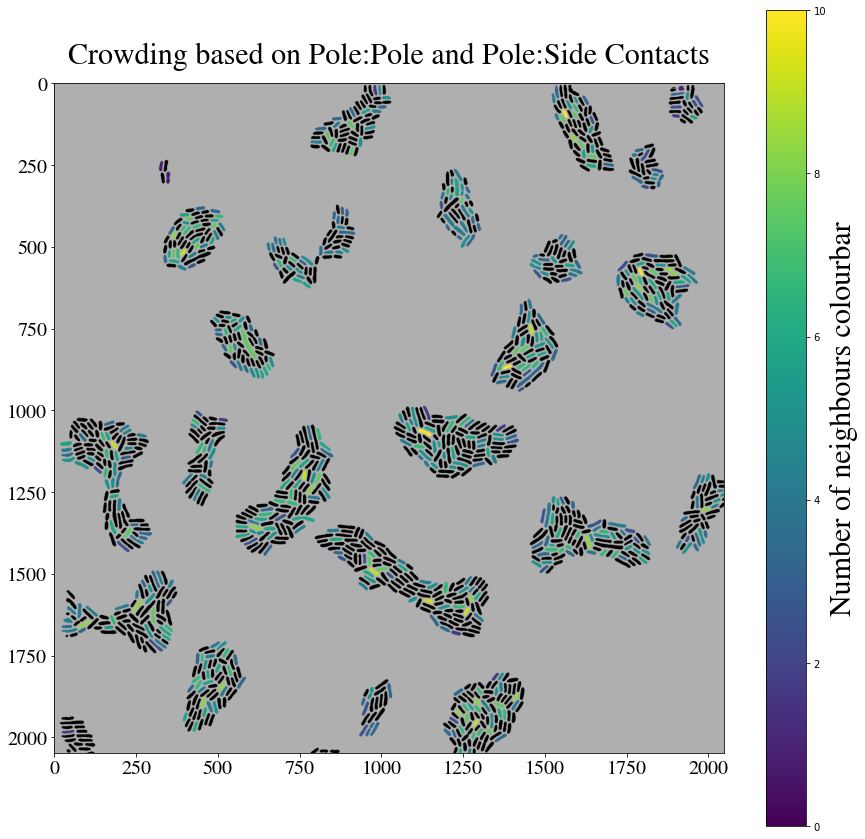

In [ ]:
import numpy as np

import matplotlib.cm as cm 

import plotly.express as px

from matplotlib.ticker import FuncFormatter



labels = processor.positions[0].rois[0].label_stack[-1]


# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )



for cell in lin.cellnumbers[-1]:
    if cell in all_ids: 
      i = max(loc for loc, val in enumerate(all_ids) if val == cell)
      c = cm.viridis((neighbours[i])/max(neighbours))
      color = c[0:3]
      # print(color)
    else: 
      color = [0,0,0]
    for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val*255

    
    

plt.figure(figsize = (15,15))
cax = plt.imshow(color_image)
# plt.pcolor(vmin=0, vmax=1)
# bar = plt.colorbar(orientation ='vertical')
plt.clim(0, 10)
# bar.set_yticklabels(fontname = 'STIXGeneral', fontsize=19)
plt.title('Crowding based on Pole:Pole and Pole:Side Contacts', fontname = 'STIXGeneral', fontsize = 30, pad = 20)
plt.xticks(fontname = 'STIXGeneral', fontsize = 20)
plt.yticks(fontname = 'STIXGeneral', fontsize = 20)

bar = plt.colorbar().set_label(label='Number of neighbours colourbar',size=30, fontname = 'STIXGeneral')
# bar.set_yticklabels(size=15,fontname = 'STIXGeneral')
plt.savefig('pp_ps_population.pdf', dpi=200)

plt.show()

### Pole to pole and pole to side contacts - plot of entire population 

In [ ]:
from numpy.ma.extras import average

def numneighbours_radialpop(population_attime):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  # total_crowdedness = []
  nums_of_neighbours = []
  # length of div cycle between two given daughters


  
  for c in population_attime:
    cell = lin.cells[c]
    npole1 = cell['new_pole'][-1]
    opole1 = cell['old_pole'][-1]
    # get centre of cell 1 for distance function 
    cell1_centre = get_centre(npole1, opole1) 
    cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
    cell_div_length = cell['length'][-1]
    neighbours = 0
    cell1_width = cell['width'][0]
    npole_new = npole1 - cell1_centre
    for c2 in population_attime:
      cell2 = lin.cells[c2]
    # for cnb2 in colony:
    #   cell2 = lin.cells[cnb2]numneighbours_radialpop
      if cell['id'] != cell2['id']:
        npole2 = cell2['new_pole'][-1]
        opole2 = cell2['old_pole'][-1]
        cell2_centre = get_centre(npole2, opole2)
        cell2_width = cell2['width'][0]
        cell2_length = cell2['length'][0]
        # if (get_cell_dist(opole1, npole2) < (2*cell1_width)) or (get_cell_dist(opole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, npole2) < (2*cell1_width)): 
        if (get_cell_dist(opole1, npole2) < (cell1_width)) or (get_cell_dist(opole1, opole2) < (cell1_width)) or (get_cell_dist(npole1, opole2) < (cell1_width)) or (get_cell_dist(npole1, npole2) < (cell1_width)): 
          neighbours = neighbours + 1
        # elif get_poleside(cell1_centre, npole1, opole1, npole2, opole2, cell1_length, cell1_width) is True:
        #   neighbours = neighbours + 1
        elif get_poleside_flipped(cell2_centre, opole1, npole1, npole2, opole2, cell2_length, cell2_width) is True:
          neighbours = neighbours + 1
      
      crowd_ids.append(cell['id'])
      nums_of_neighbours.append(neighbours)

  return crowd_ids, nums_of_neighbours

        


    #Plotting for length in relation to crowdedness 
    # print(crowd_ids, nums_of_neighbours,  div_cycle_lengths)
 
 

    # plt.xlabel('Crowdedness at division time')
    # plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  print(len(crowd_ids))
  # print(nums_of_neighbours)
  print(average(nums_of_neighbours))
  # print(div_cycle_lengths)
  print(max(nums_of_neighbours))
  






In [ ]:
all_ids, neighbors = numneighbours_radialpop(lin.cellnumbers[-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in short_scalars


In [ ]:
print(max(neighbors))

10


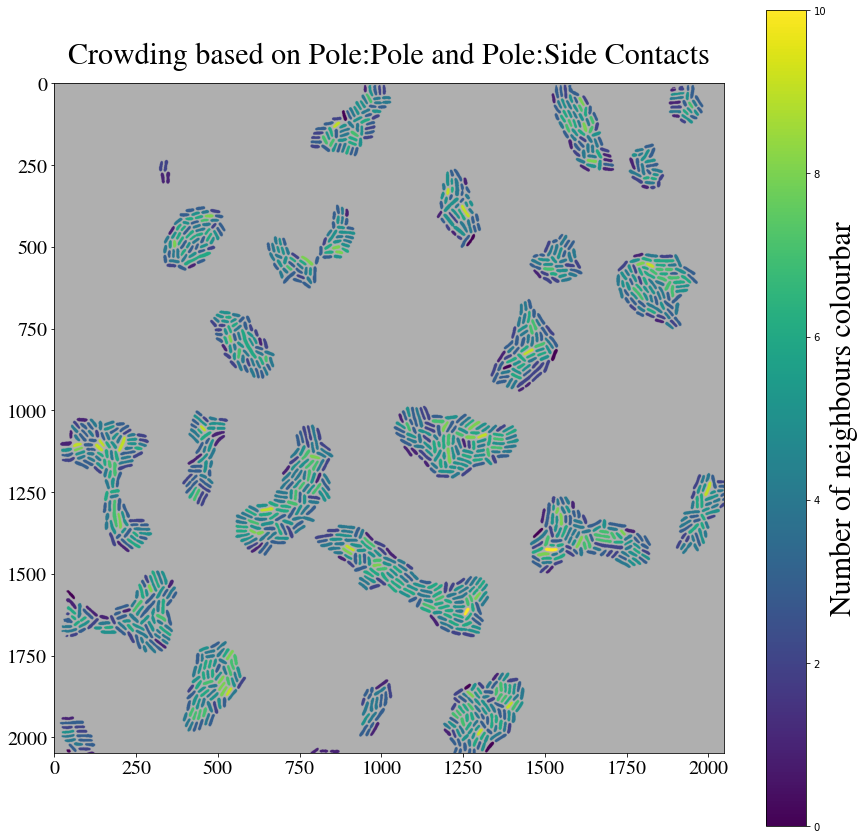

In [ ]:
import numpy as np

import matplotlib.cm as cm 

import plotly.express as px

from matplotlib.ticker import FuncFormatter



labels = processor.positions[0].rois[0].label_stack[-1]


# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )



for cell in lin.cellnumbers[-1]:
    if cell in all_ids: 
      i = max(loc for loc, val in enumerate(all_ids) if val == cell)
      c = cm.viridis((neighbors[i])/max(neighbors))
      color = c[0:3]
      # print(color)
    else: 
      color = [0,0,0]
    for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val*255

    
    

plt.figure(figsize = (15,15))
cax = plt.imshow(color_image)
# plt.pcolor(vmin=0, vmax=1)
# bar = plt.colorbar(orientation ='vertical')
plt.clim(0, 10)
# bar.set_yticklabels(fontname = 'STIXGeneral', fontsize=19)
plt.title('Crowding based on Pole:Pole and Pole:Side Contacts', fontname = 'STIXGeneral', fontsize = 30, pad = 20)
plt.xticks(fontname = 'STIXGeneral', fontsize = 20)
plt.yticks(fontname = 'STIXGeneral', fontsize = 20)

bar = plt.colorbar().set_label(label='Number of neighbours colourbar',size=30, fontname = 'STIXGeneral')
# bar.set_yticklabels(size=15,fontname = 'STIXGeneral')
plt.savefig('pp_ps_population.pdf', dpi=200)

plt.show()




In [ ]:
# plt.savefig('/Users/annaesenfeld/Desktop/pp_ps_population.pdf', dpi=200)
! ls

!





/bin/bash: line 0: cd: too many arguments


In [ ]:
import numpy as np

import matplotlib.cm as cm 

import plotly.express as px

from matplotlib.ticker import FuncFormatter



labels = processor.positions[0].rois[0].label_stack[-1]


# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )



for cell in lin.cellnumbers[-1]:
    if cell in all_ids: 
      i = max(loc for loc, val in enumerate(all_ids) if val == cell)
      c = cm.viridis((neighbors[i])/max(neighbors))
      color = c[0:3]
      # print(color)
    else: 
      color = [0,0,0]
    for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val*255

    
    

plt.figure(figsize = (15,15))
cax = plt.imshow(color_image)
# plt.pcolor(vmin=0, vmax=1)
# bar = plt.colorbar(orientation ='vertical')
plt.clim(0, 10)
# bar.set_yticklabels(fontname = 'STIXGeneral', fontsize=19)
plt.title('Crowding based on Pole:Pole and Pole:Side Contacts', fontname = 'STIXGeneral', fontsize = 23, pad = 20)
plt.xticks(fontname = 'STIXGeneral', fontsize = 15)
plt.yticks(fontname = 'STIXGeneral', fontsize = 15)

plt.colorbar().set_label(label='Colour by number of neighbours ',size=15, weight='bold', fontname = 'STIXGeneral')
plt.show()




NameError: ignored

### Pole to pole and pole to side contacts - number of neighbours radial 



In [ ]:

def numneighbours_radial(population_attime):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  # total_crowdedness = []
  nums_of_neighbours = []
  # length of div cycle between two given daughters


  
  for c in population_attime:
    cell = lin.cells[c]
    npole1 = cell['new_pole'][-1]
    opole1 = cell['old_pole'][-1]
    # get centre of cell 1 for distance function 
    cell1_centre = get_centre(npole1, opole1) 
    cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
    cell_div_length = cell['length'][-1]
    neighbours = 0
    cell1_width = cell['width'][0]
    npole_new = npole1 - cell1_centre
    for c2 in population_attime:
      cell2 = lin.cells[c2]
      if cell['id'] != cell2['id']:
        npole2 = cell2['new_pole'][-1]
        opole2 = cell2['old_pole'][-1]
        cell2_centre = get_centre(npole2, opole2)
        cell2_width = cell2['width'][0]
        cell2_length = cell2['length'][0]
        if is_in_radius(cell1_centre, cell1_length, opole2, npole2):
           neighbours = neighbours + 1
      
    
  crowd_ids.append(cell['id'])
  nums_of_neighbours.append(neighbours)

  return crowd_ids, nums_of_neighbours

        

In [ ]:
sns.histplot()

In [ ]:
crowd_ids =[]
nums_of_neighbours =[]

for c in lin.cellnumbers[-1]:
    cell = lin.cells[c]
    npole1 = cell['new_pole'][-1]
    opole1 = cell['old_pole'][-1]
    # get centre of cell 1 for distance function 
    cell1_centre = get_centre(npole1, opole1) 
    cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
    cell_div_length = cell['length'][-1]
    neighbours = 0
    cell1_width = cell['width'][0]
    for c2 in lin.cellnumbers[-1]:
      cell2 = lin.cells[c2]
      if cell['id'] != cell2['id']:
        npole2 = cell2['new_pole'][-1]
        opole2 = cell2['old_pole'][-1]
        cell2_centre = get_centre(npole2, opole2)
        cell2_width = cell2['width'][0]
        cell2_length = cell2['length'][0]
        if is_in_radius(cell1_centre, cell1_length, opole2, npole2):
           neighbours = neighbours + 1 
    crowd_ids.append(cell['id'])
    nums_of_neighbours.append(neighbours)



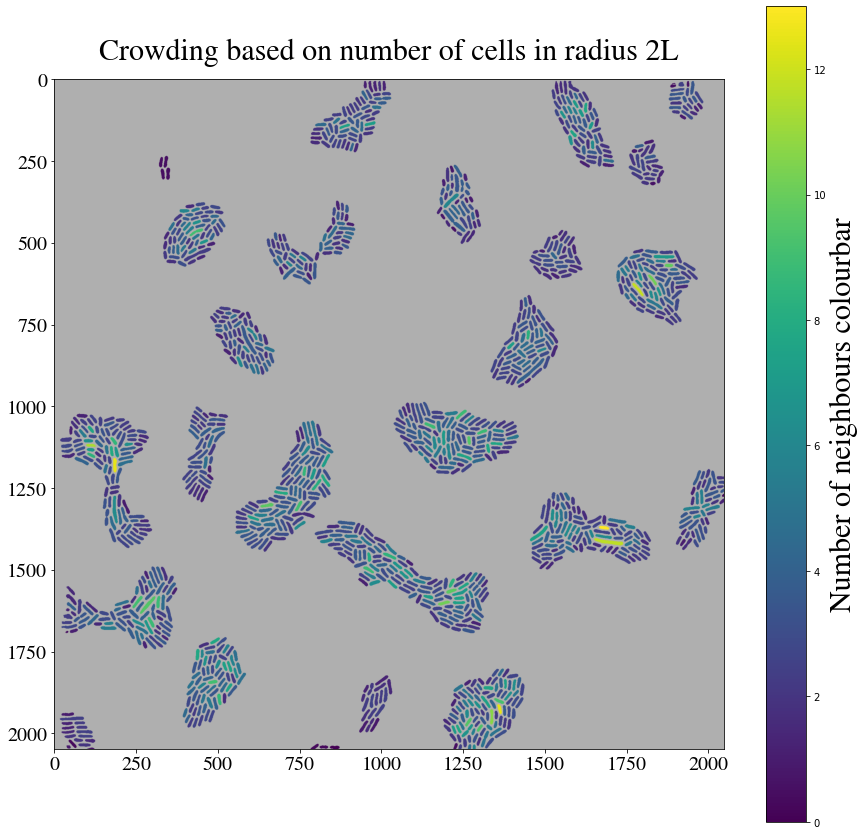

In [ ]:
import numpy as np

import matplotlib.cm as cm 

import plotly.express as px



labels = processor.positions[0].rois[0].label_stack[-1]


# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )



for cell in lin.cellnumbers[-1]:
    if cell in crowd_ids: 
      i = max(loc for loc, val in enumerate(crowd_ids) if val == cell)
      c = cm.viridis((nums_of_neighbours[i])/max(nums_of_neighbours))
      color = c[0:3]
      # print(color)
    else: 
      color = [0,0,0]
    for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val*255

    
    

plt.figure(figsize = (15,15))
cax = plt.imshow(color_image)
# plt.pcolor(vmin=0, vmax=1)
plt.clim(0,13)
plt.title('Crowding based on number of cells in radius 2L', fontname = 'STIXGeneral', fontsize = 30, pad = 20)

plt.xticks(fontname = 'STIXGeneral', fontsize = 20)
plt.yticks(fontname = 'STIXGeneral', fontsize = 20)

bar = plt.colorbar().set_label(label='Number of neighbours colourbar',size=30, fontname = 'STIXGeneral')
plt.show()


In [ ]:
crowd_ids=[]

crowdness_colony =[]


for c in lin.cellnumbers[-1]:
    cell = lin.cells[c]
    npole1 = cell['new_pole'][-1]
    opole1 = cell['old_pole'][-1]
    # get centre of cell 1 for distance function 
    cell1_centre = get_centre(npole1, opole1) 
    cell1_length = cell['length'][-1]
    crowdness = 0
    for c2 in lin.cellnumbers[-1]:
      cell2 = lin.cells[c2]
      if cell['id'] != cell2['id']:
        npole2 = cell2['new_pole'][-1]
        opole2 = cell2['old_pole'][-1]
        cell2_centre = get_centre(npole2, opole2)
        cell_distance = get_cell_dist(cell1_centre, cell2_centre)
        crowdness = crowdness + get_crowd_2(cell_distance, cell1_length )



    crowd_ids.append(cell['id'])
    crowdness_colony.append(crowdness)



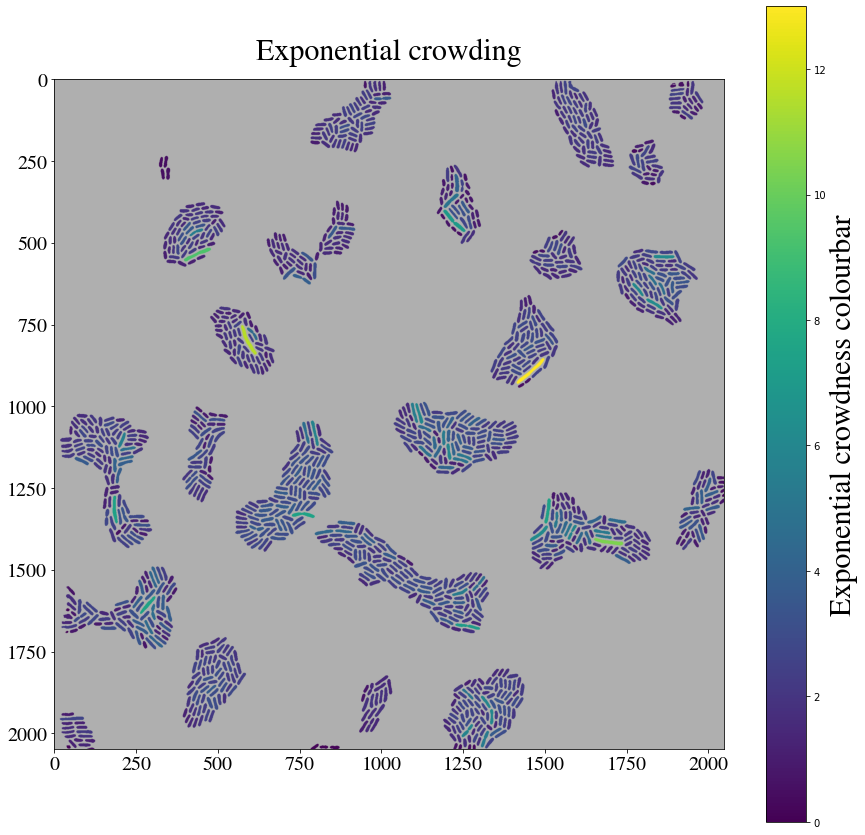

In [ ]:
labels = processor.positions[0].rois[0].label_stack[-1]


# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )


for cell in lin.cellnumbers[-1]:
    if cell in crowd_ids: 
      i = max(loc for loc, val in enumerate(crowd_ids) if val == cell)
      c = cm.viridis((crowdness_colony[i])/max(crowdness_colony))
      color = c[0:3]
      # print(color)
    else: 
      color = [0,0,0]
    for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val*255

    
    

plt.figure(figsize = (15,15))
cax = plt.imshow(color_image)
# plt.pcolor(vmin=0, vmax=1)
plt.clim(0,13)
plt.title('Exponential crowding', fontname = 'STIXGeneral', fontsize = 30, pad = 20)

plt.xticks(fontname = 'STIXGeneral', fontsize = 20)
plt.yticks(fontname = 'STIXGeneral', fontsize = 20)

bar = plt.colorbar().set_label(label='Exponential crowdness colourbar',size=30, fontname = 'STIXGeneral')
plt.show()

In [ ]:
from numpy.ma.extras import average

def numneighbours_radial(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  # total_crowdedness = []

  nums_of_neighbours = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  print(len(colony))
  
  for cnb in colony: 
    cell = lin.cells[cnb]
    # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    # print(cell['id'])
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        # print(daughter, idx)
        frame_no = cell['frames'][idx]
        # print(frame_no)
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        neighbours = 0
        cell1_width = cell['width'][0]
        npole_new = npole1 - cell1_centre
        for cell2 in lin.cells:
        # for cnb2 in colony:
        #   cell2 = lin.cells[cnb2]
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            # set cell poles 
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            cell2_centre = get_centre(npole2, opole2)
            cell2_width = cell2['width'][0]
            cell2_length = cell2['length'][0]
            if (get_cell_dist(opole1, npole2) < (2*cell1_width)) or (get_cell_dist(opole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, npole2) < (2*cell1_width)): 
              neighbours = neighbours + 1
            # elif get_poleside(cell1_centre, npole1, opole1, npole2, opole2, cell1_length, cell1_width) is True:
            #   neighbours = neighbours + 1
            elif get_poleside_flipped(cell2_centre, opole1, npole1, npole2, opole2, cell2_length, cell2_width) is True:
              neighbours = neighbours + 1
            # conditions for calculating cell cycle are different, depending if there is only one div or more
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              # print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
            # print(neighbours)
      if div_cycle > 0:
        div_cycle_lengths.append(div_cycle)
        nums_of_neighbours.append(neighbours)
        division_lengths.append(cell_div_length)
        crowd_ids.append(cell['id'])


    #Plotting for length in relation to crowdedness 
    # print(crowd_ids, nums_of_neighbours,  div_cycle_lengths)
  print(max(nums_of_neighbours))
  plt.scatter(nums_of_neighbours, div_cycle_lengths)
  plt.xlabel('Number of pole:pole or pole:side neighbours')
  plt.ylabel('Division cycle length')
  plt.title("Division length vs Number of neighbours for Wt colony of size 77 ")
  plt.xlim(0, max(nums_of_neighbours)+1)
  plt.ylim(0, max(div_cycle_lengths) +1)
  theta = np.polyfit(nums_of_neighbours, div_cycle_lengths, 1)
  y_line =[]
  for i in range(len(nums_of_neighbours)): 
    y = theta[1] + theta[0] * i
    y_line.append(y)
  plt.plot(y_line)
  plt.legend([str(theta[0]) + 'x' + ','+ str(theta[1])], loc = 'best')
  plt.figure(figsize = (15,20))
  print(theta)
    # plt.xlabel('Crowdedness at division time')
    # plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  print(len(crowd_ids))
  # print(nums_of_neighbours)
  print(average(nums_of_neighbours))
  print(average(div_cycle_lengths))
  # print(div_cycle_lengths)
  print(len(colony))
  print(max(nums_of_neighbours))
  return crowd_ids, nums_of_neighbours, div_cycle_lengths


In [ ]:
# Rework to make this work across an entire population 
from numpy.ma.extras import average
import seaborn as sns 

def numneighbours_colony_radial(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  # total_crowdedness = []

  nums_of_neighbours = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]

  
  for cnb in colony : 
    cell = lin.cells[cnb]
  # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
  # print(cell['id'])
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        # print(daughter, idx)
        frame_no = cell['frames'][idx]
        # print(frame_no)
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        neighbours = 0
        cell1_width = cell['width'][0]
        npole_new = npole1 - cell1_centre
        for cnb2 in colony:
          cell2 = lin.cells[cnb2]
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            # set cell poles 
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            cell2_centre = get_centre(npole2, opole2)
            cell2_width = cell2['width'][0]
            cell2_length = cell2['length'][0]
            if is_in_radius(cell1_centre , cell1_length ,opole2, npole2): 
              neighbours = neighbours + 1
              # if (get_cell_dist(opole1, npole2) < (2*cell1_width)) or (get_cell_dist(opole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, npole2) < (2*cell1_width)): 
              #   neighbours = neighbours + 1
              #   # elif get_poleside(cell1_centre, npole1, opole1, npole2, opole2, cell1_length, cell1_width) is True:
              #   #   neighbours = neighbours + 1
              # elif get_poleside_flipped(cell2_centre, opole1, npole1, npole2, opole2, cell2_length, cell2_width) is True:
              #   neighbours = neighbours + 1
                # conditions for calculating cell cycle are different, depending if there is only one div or more
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              # print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
              # print(neighbours)
    if div_cycle > 0:
      div_cycle_lengths.append(div_cycle)
      nums_of_neighbours.append(neighbours)
      division_lengths.append(cell_div_length)
      crowd_ids.append(cell['id'])



  # ax = sns.boxplot(nums_of_neighbours, div_cycle_lengths )
  # ax.set_xlabel('Number of neighbouring cells in raidus 2l')
  # ax.set_ylabel('Division cycle length(frames)')
  # plt.xlim(0, max(nums_of_neighbours)+1)
  # plt.ylim(0, max(div_cycle_lengths) +1)
  # plt.show()
  

    #Plotting for length in relation to crowdedness 
    # print(crowd_ids, nums_of_neighbours,  div_cycle_lengths)
  # print(max(nums_of_neighbours))
  # plt.scatter(nums_of_neighbours, div_cycle_lengths)
  # plt.xlabel('Number of pole:pole or pole:side neighbours')
  # plt.ylabel('Division cycle length')
  # plt.title("Division length vs Number of neighbours for Wt colony of size 77 ")
  # 
  # theta = np.polyfit(nums_of_neighbours, div_cycle_lengths, 1)
  # y_line =[]
  # for i in range(len(nums_of_neighbours)): 
  #   y = theta[1] + theta[0] * i
  #   y_line.append(y)
  # plt.plot(y_line)
  # plt.legend([str(theta[0]) + 'x' + ','+ str(theta[1])], loc = 'best')
  # plt.figure(figsize = (15,20))
  # print(theta)
    # plt.xlabel('Crowdedness at division time')
    # plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  # print(len(crowd_ids))
  # # print(nums_of_neighbours)
  # print(average(nums_of_neighbours))
  # print(average(div_cycle_lengths))
  # # print(div_cycle_lengths)
  # print(max(nums_of_neighbours))
  return crowd_ids, nums_of_neighbours, div_cycle_lengths






In [ ]:
c11_ids, c11_neighbs, c11_cycles = numneighbours_colony_radial(colony_1011_ref)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Number of Neighbours in 2l radius')

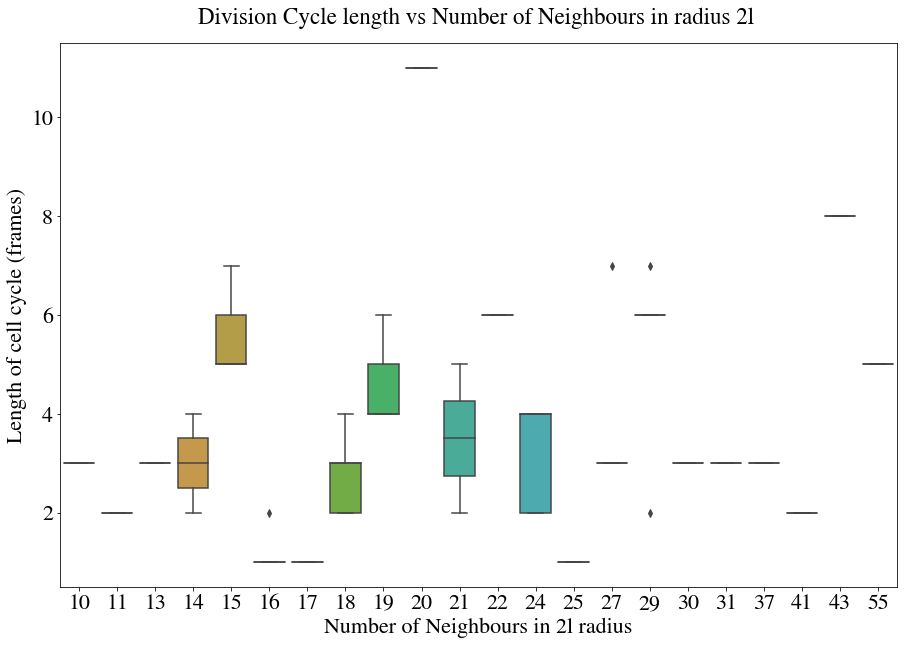

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(c11_neighbs,c11_cycles)
plt.title ('Division Cycle length vs Number of Neighbours in radius 2l ', fontname = 'STIXGeneral', fontsize = 23, pad = 20)
# ax.set_xticklabels(fontname = 'STIXGeneral', fontsize=20)
# ax.set_yticks(fontname = 'STIXGeneral', fontsize=20)
ylabels = plt.yticks(fontname = 'STIXGeneral', fontsize=22)
xlabels = plt.xticks(fontname = 'STIXGeneral', fontsize=22)
plt.ylabel('Length of cell cycle (frames)', fontname = 'STIXGeneral', fontsize=22)
plt.xlabel('Number of Neighbours in 2l radius', fontname = 'STIXGeneral', fontsize=22)


In [ ]:
colony_20 = get_colony(lin.cells, 20)
colony_21 = get_colony(lin.cells, 21)
colony_24 = get_colony(lin.cells, 24)
colony_25 = get_colony(lin.cells, 25)

colony_2 = colony_20 + colony_21 + colony_24 + colony_25


# refinement 
# plotting the crowdedness of each cell in the population at a given time (change the index of lin.cellnumbers) 
print(len(colony_2))
for cnb in colony_2:
  cell = lin.cells[cnb]
  npole1 = cell['new_pole'][-1]
  opole1 = cell['old_pole'][-1]
  # get centre of cell 1 for distance function 
  cell1_centre = get_centre(npole1, opole1)
  cell1_length = get_length_alt(npole1, opole1)
  cell1_width = cell['width'][0]
  for cnb2 in lin.cellnumbers[-1]:
    if cnb2 not in  colony_2:
      cell2 = lin.cells[cnb2]
      npole2 = cell2['new_pole'][-1]
      opole2 = cell2['old_pole'][-1]
      cell2_centre = get_centre(npole2, opole2)
      if (get_cell_dist(opole1, npole2) < (2*cell1_width)) or (get_cell_dist(opole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, npole2) < (2*cell1_width)): 
        if cell2['id'] not in colony_2:
          colony_2.append(cnb2)
    # elif get_poleside(cell1_centre, npole1, opole1, npole2, opole2, cell1_length, cell1_width) is True:
    #   colony_2.append(cnb2)

print(len(colony_2))



123
168


In [ ]:
colony_3 = []

colony_19 = get_colony(lin.cells, 19)
colony_28= get_colony(lin.cells, 28)
colony_54 = get_colony(lin.cells, 54)

colony_3 = colony_19 + colony_28 + colony_54


print(len(colony_3))
for cnb in colony_3:
  cell = lin.cells[cnb]
  npole1 = cell['new_pole'][-1]
  opole1 = cell['old_pole'][-1]
  # get centre of cell 1 for distance function 
  cell1_centre = get_centre(npole1, opole1)
  cell1_length = get_length_alt(npole1, opole1)
  cell1_width = cell['width'][0]
  for cnb2 in lin.cellnumbers[-1]:
    if cnb2 not in  colony_3:
      cell2 = lin.cells[cnb2]
      npole2 = cell2['new_pole'][-1]
      opole2 = cell2['old_pole'][-1]
      cell2_centre = get_centre(npole2, opole2)
      if (get_cell_dist(opole1, npole2) < (2*cell1_width)) or (get_cell_dist(opole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, npole2) < (2*cell1_width)): 
        if cell2['id'] not in colony_3:
          colony_3.append(cnb2)
    # elif get_poleside(cell1_centre, npole1, opole1, npole2, opole2, cell1_length, cell1_width) is True:
    #   colony_2.append(cnb2)

print(len(colony_3))




98
137


In [ ]:
import numpy as np

import matplotlib.cm as cm 

import plotly.express as px

labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# col_1011_cids, col_1011_neighbours, col_1011_cycles = numneighbours_radial(colony_1011)
col_2_cids, col_2_neighbours, col_2_cycles = numneighbours_radial(colony_2)

# for cell in lin.cellnumbers[-1]:
#   if cell in colony_1011:
#     if cell in col_1011_cids: 
#       i = max(loc for loc, val in enumerate(col_1011_cids) if val == cell)
#       c = cm.viridis((col_1011_neighbours[i])/10)
#       color = c[0:3]
#       # print(color)
#   else: 
#     color = [0,0,0]
#   for c, val in enumerate(color):
#     color_image[:,:,c][labels==cell+1]=val*255

for cell in lin.cellnumbers[-1]:
  if cell in colony_2:
    if cell in col_2_cids: 
      i = max(loc for loc, val in enumerate(col_2_cids) if val == cell)
      c = cm.viridis((col_2_neighbours[i])/12)
      color = c[0:3]
      # print(color)
  else: 
    color = [0,0,0]
  for c, val in enumerate(color):
    color_image[:,:,c][labels==cell+1]=val*255


    
    
    
    
        


plt.figure(figsize = (15,15))
plt.imshow(color_image)
plt.colorbar()
plt.show()


NameError: ignored

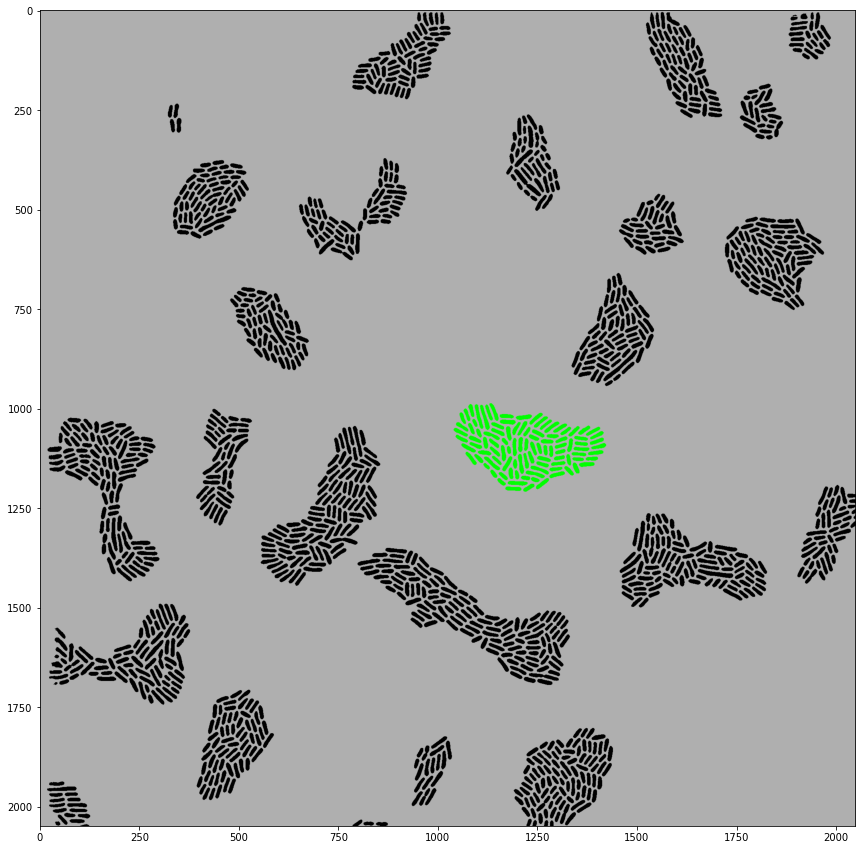

In [ ]:
import numpy as np
import matplotlib.cm  as cm 



labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )



# col_1011_cids, col_1011_neighbours, col_1011_cycles = numneighbours_radial(colony_1011)

for cell in lin.cellnumbers[-1]:
  if cell in colony_2:
    # color =  col_1011_neighbours
    color = [0,255,0]
  else: 
     color = [0,0,0]


  for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val
      



plt.figure(figsize = (15,15))
plt.imshow(color_image)
plt.show()

In [ ]:
# code to calculate crowdedness during a division event 
import math
import numpy as np

def get_centre(npole, opole): # get cell centre, using the coordinates between two poles of the cell 
  cell_centre = ((npole[0] + opole[0])/2 ,  (npole[1] + opole[1])/2)
  return cell_centre

def get_cell_dist(centre1, centre2): # get the distance between two cell centres 
  # dist = ((centre1[0] + centre2[0])/2 ,  (centre1[1] + centre2[1])/2)
  dist = math.sqrt(((centre1[0] - centre2[0])**2 + (centre1[1] - centre2[1])**2))
  return dist

def get_crowd_2(cell_dist, cell_length):
  crowd = math.e**((-cell_dist/cell_length))
  return crowd

# not useful - use centre 
def is_neighbour(centre1, c2_opole, c2_npole, cell1_l0):
  dist_opole = math.sqrt(((centre1[0] - c2_opole[0])**2 + (centre1[1] - c2_opole[1])**2))
  dist_npole = math.sqrt(((centre1[0] - c2_npole[0])**2 + (centre1[1] - c2_npole[1])**2))
  if dist_opole < 2*cell1_l0 or dist_npole < 2*cell1_l0: 
    return True 
  else: 
    return False 

def is_in_radius(centre1,cell1_l0,c2_opole, c2_npole): 
  radius = cell1_l0
  return(((c2_opole[0] - centre1[0])**2 + (c2_opole[1] - centre1[1])**2) < radius **2 or  ((c2_npole[0] - centre1[0])**2 + (c2_npole[1] - centre1[1])**2) < radius **2)
  
def get_length_alt(npole, opole):
  cell_length = math.sqrt((opole[0]- npole[0])**2 + (opole[1]- npole[1])**2)
  return cell_length

def get_poleside(centre1, opole1, npole1, npole2, opole2, cell1_length, cell1_width):
  # substracting the coordinates of the centre of cell1 ( the cell in question) from the poles of all cells 
  # After this, the centre of cell 1 lies at 0,0 
  opole1_new = [opole1[0] - centre1[0], centre1[1] - centre1[1]]
  npole1_new = [npole1[0] - centre1[0] , centre1[1] - centre1[1]]
  npole2_new = [npole2[0] - centre1[0] , npole2[1] - centre1[1]]
  opole2_new = [opole2[0] - centre1[0] , opole2[1] - centre1[1]]
  # tan theta for cell 1: y(npole)- y(opole) / x(npole) -x(opole)
  # opole and npole is just delta nomenclature for the 2 poles 
  tantheta = (opole1[1]- npole1[1]) / (opole1[0]- npole1[0])
  # using arctan to get theta 
  theta = math.atan(tantheta)
  #  creating a rotation matrix, rot using the theta obtained 
  rot = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
  # multiplying each coordinate by rotation matrix to perform rotation
  opole1_rot = np.dot(rot, opole1_new)
  npole1_rot = np.dot(rot, npole1_new)
  opole2_rot = np.dot(rot, opole2_new)    
  npole2_rot = np.dot(rot, npole2_new)
  neg_cell_length = -cell1_length
  # now for each pole of cell 2 : 
  # first checking that the x coordinate lies within the length of cell 1 
  if ( neg_cell_length/2 < npole2_rot[0] < cell1_length/2): 
    # if that is the case, checking that the y coordinate is within 2w of cell1 
    if  npole2_rot[1] < 2*cell1_width:
      return True 
  elif ( neg_cell_length < opole2_rot[0] < cell1_length):
    if  opole2_rot[1] < 2*cell1_width:
      return True
 

  # if abs(npole2_rot[0]) < cell1_length:
  #   if  npole2_rot[1] < 2*cell1_width:
  #      return True 
  # elif abs(opole2_rot[0]) < cell1_length:
  #   if  opole2_rot[1] < 2*cell1_width:
  #     return True



### Calculating number of neighbours in a 2L raidus

In [ ]:
from numpy.ma.extras import average
def numneighbours_radial(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  # total_crowdedness = []

  nums_of_neighbours = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  print(len(colony))
  
  for cnb in colony: 
    cell = lin.cells[cnb]
    # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    # print(cell['id'])
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        # print(daughter, idx)
        frame_no = cell['frames'][idx]
        # print(frame_no)
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        neighbours = 0
        cell1_width = cell['width'][0]
        npole_new = npole1 - cell1_centre
        for cell2 in lin.cells:
        # for cnb2 in colony:
        #   cell2 = lin.cells[cnb2]
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            # set cell poles 
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            cell2_centre = get_centre(npole2, opole2)
            if (get_cell_dist(opole1, npole2) < (2*cell1_width)) or (get_cell_dist(opole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, npole2) < (2*cell1_width)): 
              neighbours = neighbours + 1
              # if cell2['id'] not in colony: 
              #     colony.append(cell2['id'])
            # elif get_poleside(cell1_centre, npole1, opole1, npole2, opole2, cell1_length, cell1_width) is True:
            #   neighbours = neighbours + 1
            #   if cell2['id'] not in colony: 
            #       colony.append(cell2['id'])
              # print(neighbours)
            # conditions for calculating cell cycle are different, depending if there is only one div or more
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              # print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
            # print(neighbours)
      if div_cycle > 0:
        div_cycle_lengths.append(div_cycle)
        nums_of_neighbours.append(neighbours)
        division_lengths.append(cell_div_length)
        crowd_ids.append(cell['id'])


    #Plotting for length in relation to crowdedness 
    # print(crowd_ids, nums_of_neighbours,  div_cycle_lengths)
  print(max(nums_of_neighbours))
  plot = plt.scatter(nums_of_neighbours, div_cycle_lengths)
  plt.xlabel('Number of Neighbours in raidus 2L0')
  plt.ylabel('Crowdedness at division time')
  plt.title("Division length vs Number of neighbours for Wt colony of size 77 ")
    # plt.xlabel('Crowdedness at division time')
    # plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  print(len(crowd_ids))
  # print(nums_of_neighbours)
  print(average(nums_of_neighbours))
  print(average(div_cycle_lengths))
  # print(div_cycle_lengths)
  print(len(colony))
  print(max(nums_of_neighbours))
  return crowd_ids, nums_of_neighbours, div_cycle_lengths


88
8
38
4.894736842105263
3.8421052631578947
88
8


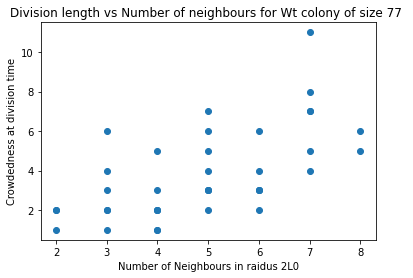

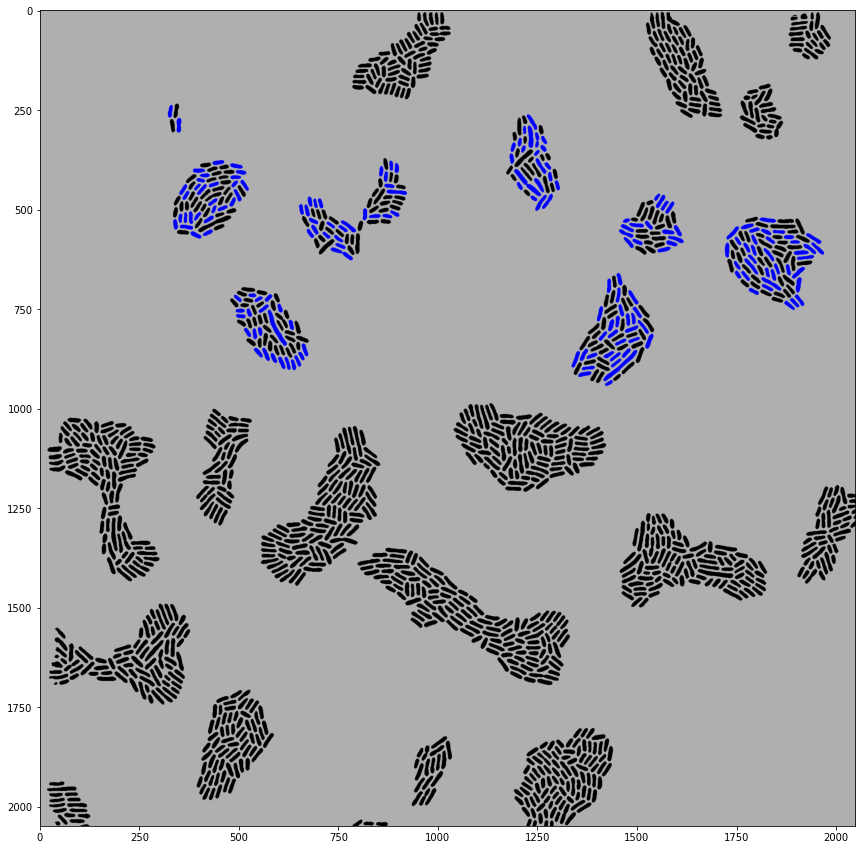

88
8
38
4.894736842105263
3.8421052631578947
88
8
(0.172719, 0.448791, 0.557885, 1.0)


IndexError: ignored

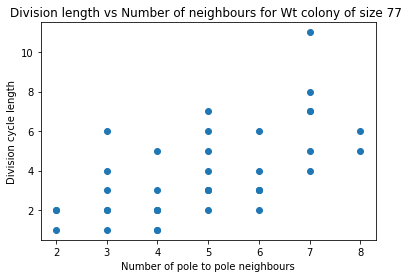

In [ ]:
import numpy as np

import matplotlib.cm as cm 

import plotly.express as px

labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

col_1011_cids, col_1011_neighbours, col_1011_cycles = numneighbours_radial(colony_1011)

for cell in lin.cellnumbers[-1]:
  if cell in colony_1011:
    if cell in col_1011_cids: 
      i = max(loc for loc, val in enumerate(col_1011_cids) if val == cell)
      color = cm.viridis((col_1011_neighbours[i])/8)
      print(color)
      for c, val in enumerate(color):
        color_image[:,:,c][labels==cell+1]=val*255
    else: 
      color = [0,0,0]
      for c, val in enumerate(color):
        color_image[:,:,c][labels==cell+1]=val
    
      
        


plt.figure(figsize = (15,15))
plt.imshow(color_image)
# plt.pcolor(vmin=0, vmax=1)
plt.colorbar()
plt.show()


In [ ]:
f

## Calculating number of neighbours based on pole/pole and side side 

In [ ]:
def numneighbours_poleside(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  # total_crowdedness = []

  nums_of_neighbours = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  
  for cnb in colony: 
    cell = lin.cells[cnb]
    # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    # print(cell['id'])
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        # print(daughter, idx)
        frame_no = cell['frames'][idx]
        # print(frame_no)
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        neighbours = 0
        for cell2 in lin.cells:
        # for cnb2 in colony:
          # cell2 = lin.cells[cnb2]
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            # set cell poles 
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            # nb = is_in_raidus( cell1_centre , cell1_length,opole2,npole2)
            # print(nb)
            cell2_centre = get_centre(npole2, opole2) 
            if 
              neighbours = neighbours + 1
              # print(neighbours)
            # conditions for calculating cell cycle are different, depending if there is only one div or more
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              # print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
            # print(neighbours)
        if div_cycle > 0:
          div_cycle_lengths.append(div_cycle)
          nums_of_neighbours.append(neighbours)
          division_lengths.append(cell_div_length)
          crowd_ids.append(cell['id'])


    #Plotting for length in relation to crowdedness 
    # print(crowd_ids, nums_of_neighbours,  div_cycle_lengths)
  plot = plt.scatter(nums_of_neighbours, div_cycle_lengths)
  plt.xlabel('Number of Neighbours at distance < L0 ')
  plt.ylabel('Division cycle lengths')
  plt.title("Division length vs Number of neighbours for Wt colony of size 77 ")
    # plt.xlabel('Crowdedness at division time')
    # plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  print(len(crowd_ids))
  print(nums_of_neighbours)
  print(div_cycle_lengths)
  print(average(nums_of_neighbours))
  print(average(div_cycle_lengths))
  return crowd_ids, nums_of_neighbours, div_cycle_lengths




SyntaxError: ignored

## Plot by distance between centres < L 

In [ ]:
def numneighbours_immediate(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  # total_crowdedness = []

  nums_of_neighbours = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  
  for cnb in colony: 
    cell = lin.cells[cnb]
    # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    # print(cell['id'])
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        # print(daughter, idx)
        frame_no = cell['frames'][idx]
        # print(frame_no)
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        neighbours = 0
        for cell2 in lin.cells:
        # for cnb2 in colony:
          # cell2 = lin.cells[cnb2]
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            # set cell poles 
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            # nb = is_in_raidus( cell1_centre , cell1_length,opole2,npole2)
            # print(nb)
            cell2_centre = get_centre(npole2, opole2) 
            if get_cell_dist( cell1_centre, cell2_centre) < cell1_length: 
              neighbours = neighbours + 1
              # print(neighbours)
            # conditions for calculating cell cycle are different, depending if there is only one div or more
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              # print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
            # print(neighbours)
        if div_cycle > 0:
          div_cycle_lengths.append(div_cycle)
          nums_of_neighbours.append(neighbours)
          division_lengths.append(cell_div_length)
          crowd_ids.append(cell['id'])


    #Plotting for length in relation to crowdedness 
    # print(crowd_ids, nums_of_neighbours,  div_cycle_lengths)
  plot = plt.scatter(nums_of_neighbours, div_cycle_lengths)
  plt.xlabel('Number of Neighbours at distance < L0 ')
  plt.ylabel('Division cycle lengths')
  plt.title("Division length vs Number of neighbours for Wt colony of size 77 ")
    # plt.xlabel('Crowdedness at division time')
    # plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  print(len(crowd_ids))
  print(nums_of_neighbours)
  print(div_cycle_lengths)
  print(average(nums_of_neighbours))
  print(average(div_cycle_lengths))
  return crowd_ids, nums_of_neighbours, div_cycle_lengths




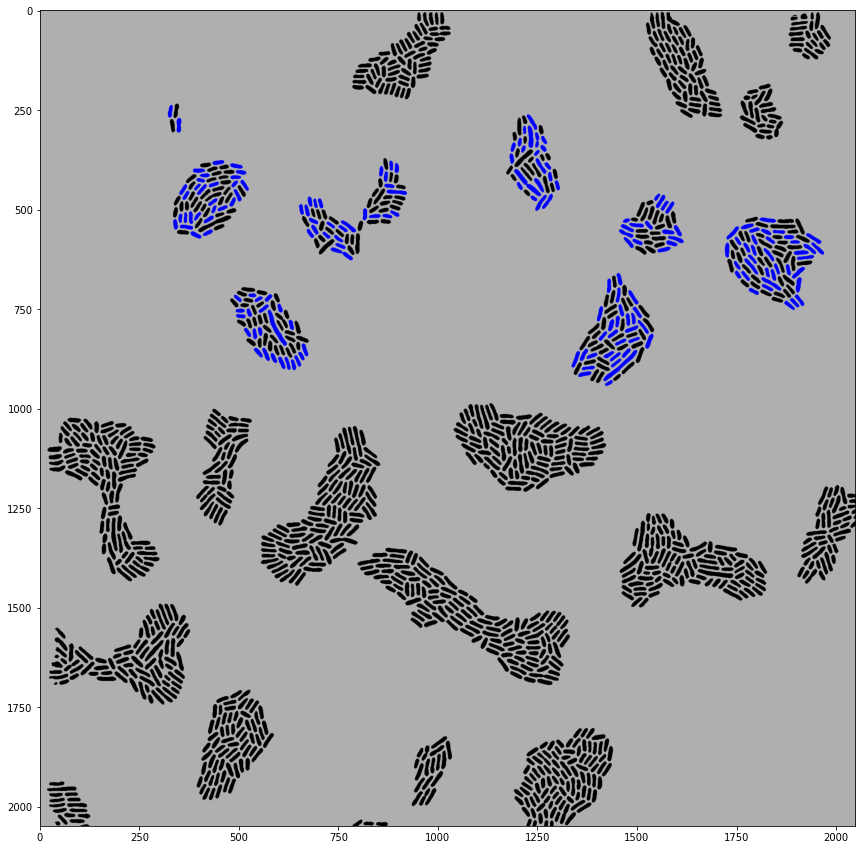

In [ ]:
import numpy as np

labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# col_1011_cids, col_1011_neighbours, col_1011_cycles = numneighbours_immediate(colony_1011)

for cell in lin.cellnumbers[-1]:
  if cell in col_1011_cids:
    # i = max(loc for loc, val in enumerate(col_1011_cids) if val == cell)
    # # if col_1011_neighbours[i] >= 3 and col_1011_cycles[i] >= 3:
    # if col_1011_neighbours[i] >= 3:
    color = [0,0,255]
  else: 
     color = [0,0,0]


  for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val
      



plt.figure(figsize = (15,15))
plt.imshow(color_image)

### Crowdness Plot 


66
5.053629937272257
3.287878787878788


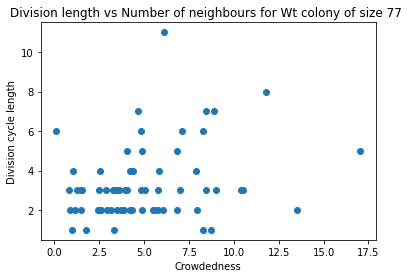

In [ ]:
def crowdedness_col(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  total_crowdedness = []

  nums_of_neighbours = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  
  for cnb in colony: 
    cell = lin.cells[cnb]
    # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    # print(cell['id'])
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        # print(daughter, idx)
        frame_no = cell['frames'][idx]
        # print(frame_no)
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        crowdedness = 0
        for cnb2 in colony:
          cell2 = lin.cells[cnb2]
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            # set cell poles 
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            # nb = is_in_raidus( cell1_centre , cell1_length,opole2,npole2)
            # print(nb)
            cell2_centre = get_centre(npole2, opole2) 
            cell_dist = get_cell_dist(cell1_centre, cell2_centre)
            crowd_pair = get_crowd_2(cell_dist, cell1_length)
            crowdedness = crowdedness + crowd_pair
              # print(neighbours)
            # conditions for calculating cell cycle are different, depending if there is only one div or more
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              # print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
            # print(neighbours)
        if div_cycle > 0:
          div_cycle_lengths.append(div_cycle)
          # nums_of_neighbours.append(neighbours)
          total_crowdedness.append(crowdedness)
          division_lengths.append(cell_div_length)
          crowd_ids.append(cell['id'])


    #Plotting for length in relation to crowdedness 
    # print(crowd_ids, nums_of_neighbours,  div_cycle_lengths)
  plot = plt.scatter(total_crowdedness, div_cycle_lengths)
  plt.xlabel('Crowdedness')
  plt.ylabel('Division cycle length')
  plt.title("Division length vs Number of neighbours for Wt colony of size 77 ")
    # plt.xlabel('Crowdedness at division time')
    # plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  print(len(crowd_ids))
  print(average(total_crowdedness))
  print(average(div_cycle_lengths))
  return div_cycle_lengths

div_lengths = crowdedness_col(colony_1011)

## Plotting

#### Plotting by number of immediate neighbours 

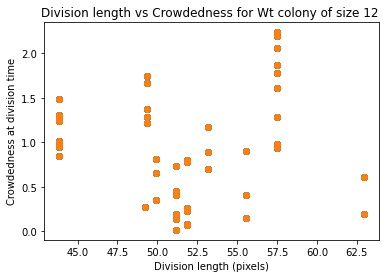

In [ ]:
# plot

import numpy as np

labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# for cell in lin.cellnumbers[-1]:
#   if cell in crowd_ids:
#     i = max(loc for loc, val in enumerate(crowd_ids) if val == cell)
#     # print(i)
#     if pop_crowdedness[i] > 50 : 
#       # print('more crowded')
#       color = [255,0,0]
#     elif pop_crowdedness[i] <= 50:
#       # print('less crowded')
#       color = [0,0,255]
#     else: 
#       color = [0,0,0]
#       # print('idk')

# for cell in lin.cellnumbers[-1]:
#   if cell in crowd_ids:
#     i = max(loc for loc, val in enumerate(crowd_ids) if val == cell)
#     # print(i)
#     if pop_div_lengths[i] > 50 : 
#       # print('more crowded')
#       color = [0,0,255]
#     elif pop_div_lengths[i] <= 50:
#       # print('less crowded')
#       color = [255,0,0]
#     else: 
#       color = [0,0,0]
#       # print('idk')

for cell in lin.cellnumbers[-1]:
  if cell in col_1011_cids:
    i = max(loc for loc, val in enumerate(col_1011_cids) if val == cell)
    if col_1011_crowdedness[i] > 6 and col_1011_cycle_lengths[i] >= 3:
      color = [0,0,255]
    elif 
  else: 
      color = [0,0,0]


  for c, val in enumerate(color):
    color_image[:,:,c][labels==cell+1]=val
    
      


# for cnb in lin.cellnumbers[-1]:
#   for lst in colony_list: 
#     # print(cnb)
#     # print(lst)
#     if cnb in lst: 
#       i = colony_list.index(lst)
#       color = c_colony[i]

#       for c, val in enumerate(color):
#         color_image[:,:,c][labels==cnb+1]=val
   


plt.figure(figsize = (15,15))
plt.imshow(color_image)
plt.show()




In [ ]:
def get_colony(cells, mother_id):
  colony = []
  colony.append(mother_id)
  for cell in lin.cells:
    if cell['mother'] == mother_id or cell['mother'] in colony:
      colony.append(cell['id'])
                    
  return colony 


colony_10 = get_colony(lin.cells, 10)
colony_11 = get_colony(lin.cells, 11)
colony_1011 = colony_10 + colony_11

#### Plotting distribution of division lengths 


In [ ]:
def crowdedness_col(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  total_crowdedness = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  for cnb in colony: 
    cell = lin.cells[cnb]
    # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    crowdedness = 0 #assign crowdedness to zero initially 
    # print(cell['id'])
    # print(daughters)
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        frame_no = cell['frames'][idx]
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        for cnb2 in colony:
          cell2 = lin.cells[cnb2]
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            cell2_centre = get_centre(npole2, opole2)
            # get distance between the two centre points 
            cell_dist = get_cell_dist(cell1_centre, cell2_centre)
            crowd_pair = get_crowd_2(cell_dist, cell1_length)
            crowdedness = crowdedness + crowd_pair 
            # conditions for calculating cell cycle are different, depending if there is only one div or more
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              # print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
            div_cycle_lengths.append(div_cycle)
            total_crowdedness.append(crowdedness)
            division_lengths.append(cell_div_length)
            crowd_ids.append(cell['id'])

    plot = plt.scatter(total_crowdedness, div_cycle_lengths)
    plt.xlabel('Crowdedness at division time')
    plt.ylabel('Division cycle length ')
  return div_cycle_lengths
  # return division_lengths



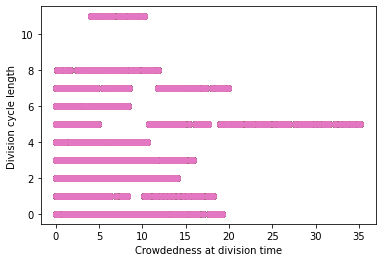

In [ ]:
col_1011_cids = crowdedness_col(colony_1011)

In [ ]:
print(col_1011_cids)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,

In [ ]:
print(col_1011_crowdedness )

[0.18577901019489937, 0.9543277483269704, 1.140631758524847, 1.9366524394949902, 2.7079805638329755, 3.277842044886638, 3.482797741745863, 3.6553483620341347, 4.345150303484665, 4.699112326005436, 4.989649416906193, 5.6582490834543, 6.163343491749561, 6.661844863503607, 7.099540705780367, 7.625634692709124, 8.169215450552336, 8.524978541882122, 8.797348615347744, 9.083749874269223, 9.431701916171711, 10.137011284091246, 10.478034187217874, 10.723296905624261, 11.3499909392977, 11.681189962224684, 12.184082754288172, 12.581555133280109, 13.067421427568148, 13.501732288240747, 14.095140470966516, 14.724162501671712, 15.125471864683163, 15.440984626807829, 15.797426609189886, 16.23583799012057, 16.551527854813994, 16.922874383760256, 17.41398041924749, 17.8249637336682, 18.13439242683465, 18.930131102791094, 19.167343894744302, 19.56333508950585, 19.689676555141283, 19.85828716057375, 19.968225274792978, 20.391610885203132, 20.671052024666043, 20.90964084513335, 21.162403174898913, 21.276

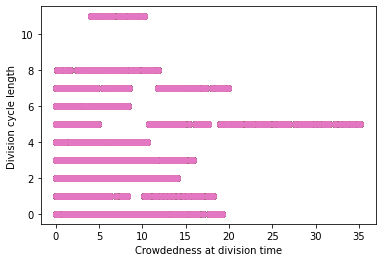

In [ ]:


col_1011_cycle_lengths = crowdedness_col(colony_1011)

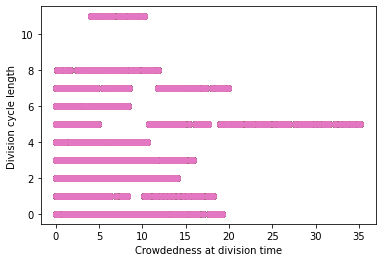

In [ ]:
col_1011_crowdedness = crowdedness_col(colony_1011)

55.0670318508662

6.241107359736093

Division length
mean 50.295353296640755 sd 14.682183806545208


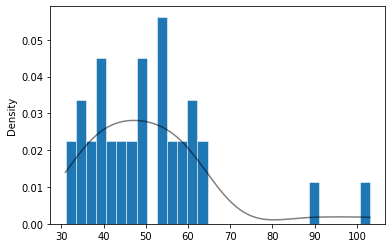

In [ ]:
import seaborn as sns
import statistics
  
ax1 = sns.histplot(div_lengths, bins=30, stat='density', alpha= 1, kde=True,
                    edgecolor='white', linewidth=0.5,
                    line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
ax1.get_lines()[0].set_color('black')
mn = statistics.mean(div_lengths)
sd = statistics.stdev(div_lengths)

print('Division length')
print('mean', mn, 'sd' , sd)


In [ ]:
def crowdedness_col(population):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  total_crowdedness = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  for cell in population: 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    crowdedness = 0 #assign crowdedness to zero initially 
    # print(cell['id'])
    # print(daughters)
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        frame_no = cell['frames'][idx]
        if frame_no < 23: 
          npole1 = cell['new_pole'][idx]
          opole1 = cell['old_pole'][idx]
          # get centre of cell 1 for distance function 
          cell1_centre = get_centre(npole1, opole1) 
          cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
          cell_div_length = cell['length'][idx]
          daughter_index = daughters.index(daughter)
          if len(daughters) > 1 and daughter_index > 0:
            prev_daughter = daughters[daughter_index-1]
            # print(daughter, prev_daughter)
            div_cycle = frame_no - cell['frames'][prev_daughter]
          else:
            div_cycle = frame_no - cell['frames'][0]
          # print('div_cycle',div_cycle)
          div_cycle_lengths.append(div_cycle)
          for cell2 in population: 
            if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
              idx2 = cell2['frames'].index(frame_no)
              npole2 = cell2['new_pole'][idx2]
              opole2 = cell2['old_pole'][idx2]
              cell2_centre = get_centre(npole2, opole2)
              # get distance between the two centre points 
              cell_dist = get_cell_dist(cell1_centre, cell2_centre)
              crowd_pair = get_crowd_2(cell_dist, cell1_length)
              crowdedness = crowdedness + crowd_pair 
              # conditions for calculating cell cycle are different, depending if there is only one div or more
          # print(crowdedness)
          total_crowdedness.append(crowdedness)
          crowd_ids.append(cell['id'])
          division_lengths.append(cell_div_length)



  plot = plt.scatter(division_lengths, total_crowdedness)
  plt.xlabel('Division length (pixels)')
  plt.ylabel('Crowdedness at division time')
  plt.title("Division length vs Crowdedness for entire Wt population")
  plt.show()
  # plot = plt.scatter(total_crowdedness,div_cycle_lengths )
  # plt.xlabel('Crowdedness at division time')
  # plt.ylabel('Division cycle length ')
  return total_crowdedness
  






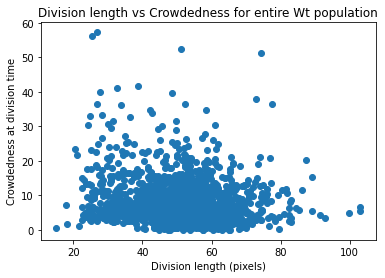

In [ ]:
crowd_ids = crowdedness_col(lin.cells)

In [ ]:
print(pop_div_lengths)

[47.48617172241211, 51.363033294677734, 40.697021484375, 57.870399475097656, 48.280799865722656, 52.49734878540039, 29.516094207763672, 70.28729248046875, 63.14939498901367, 52.55415344238281, 81.03862762451172, 57.719757080078125, 58.12874221801758, 49.05966567993164, 57.03287887573242, 57.03984069824219, 48.65958786010742, 47.932498931884766, 54.03156280517578, 62.424983978271484, 58.68986129760742, 60.37899398803711, 57.54602813720703, 61.61157989501953, 61.10234069824219, 51.87677764892578, 61.893333435058594, 60.82155227661133, 59.75642776489258, 59.26237869262695, 51.45082473754883, 61.98462677001953, 53.83513259887695, 40.18896484375, 52.599998474121094, 53.0081787109375, 45.59669494628906, 45.45692443847656, 49.72823715209961, 56.224456787109375, 67.05986022949219, 41.0, 42.928802490234375, 58.187522888183594, 68.0849380493164, 48.63624572753906, 56.04477310180664, 62.068702697753906, 46.04084014892578, 48.5066032409668, 65.12247467041016, 69.0513687133789, 56.08018112182617, 4

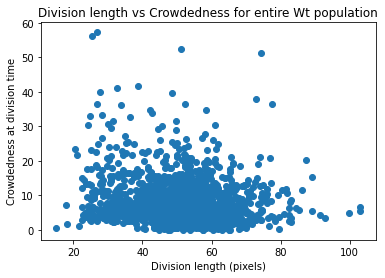

In [ ]:
pop_div_lengths = crowdedness_col(lin.cells)

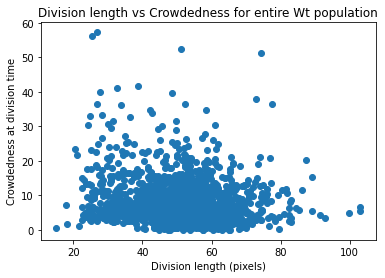

In [ ]:
pop_crowdedness = crowdedness_col(lin.cells)

In [ ]:
sum(pop_div_lengths)/ len(pop_div_lengths)

50.97250040918851

In [ ]:
for cnb in crowd_ids: 
  i = max(loc for loc, val in enumerate(crowd_ids) if val == cnb)
  print(i)

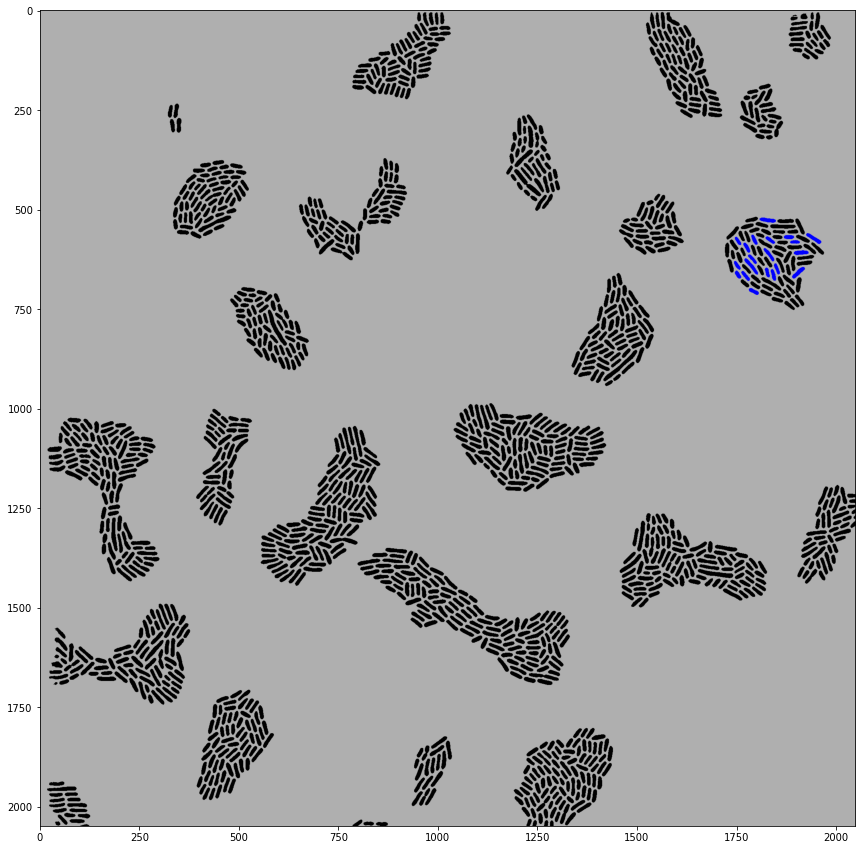

In [ ]:
# plot

import numpy as np

labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# for cell in lin.cellnumbers[-1]:
#   if cell in crowd_ids:
#     i = max(loc for loc, val in enumerate(crowd_ids) if val == cell)
#     # print(i)
#     if pop_crowdedness[i] > 50 : 
#       # print('more crowded')
#       color = [255,0,0]
#     elif pop_crowdedness[i] <= 50:
#       # print('less crowded')
#       color = [0,0,255]
#     else: 
#       color = [0,0,0]
#       # print('idk')

# for cell in lin.cellnumbers[-1]:
#   if cell in crowd_ids:
#     i = max(loc for loc, val in enumerate(crowd_ids) if val == cell)
#     # print(i)
#     if pop_div_lengths[i] > 50 : 
#       # print('more crowded')
#       color = [0,0,255]
#     elif pop_div_lengths[i] <= 50:
#       # print('less crowded')
#       color = [255,0,0]
#     else: 
#       color = [0,0,0]
#       # print('idk')

for cell in lin.cellnumbers[-1]:
  if cell in col_1011_cids:
    i = max(loc for loc, val in enumerate(col_1011_cids) if val == cell)
    if col_1011_crowdedness[i] > 6 and col_1011_cycle_lengths[i] >= 3:
      color = [0,0,255]
    elif 
  else: 
      color = [0,0,0]


  for c, val in enumerate(color):
    color_image[:,:,c][labels==cell+1]=val
    
      


# for cnb in lin.cellnumbers[-1]:
#   for lst in colony_list: 
#     # print(cnb)
#     # print(lst)
#     if cnb in lst: 
#       i = colony_list.index(lst)
#       color = c_colony[i]

#       for c, val in enumerate(color):
#         color_image[:,:,c][labels==cnb+1]=val
   


plt.figure(figsize = (15,15))
plt.imshow(color_image)
plt.show()



In [ ]:
print(col_1011_cycle_lengths)

[0, 1, 1, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
(sum(col_1011_cycle_lengths))/(len(col_1011_cycle_lengths))

3.329465395772897

Division lengths population
mean 50.295353296640755 sd 14.682183806545208


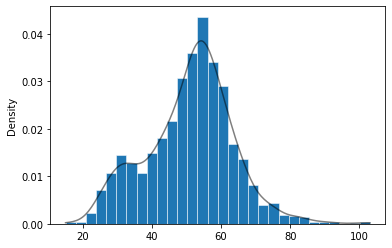

In [ ]:
import seaborn as sns
import statistics

for cell in lin.cells: 
  init_length = cell['length'][0]
  

  
ax1 = sns.histplot(div_cycles, bins=30, stat='density', alpha= 1, kde=True,
                    edgecolor='white', linewidth=0.5,
                    line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
ax1.get_lines()[0].set_color('black')
mn = statistics.mean(division_lengths)
sd = statistics.stdev(division_lengths)


print('Division lengths population')
print('mean', mn, 'sd', sd)

Division lengths population
mean 50.295353296640755 sd 14.682183806545208


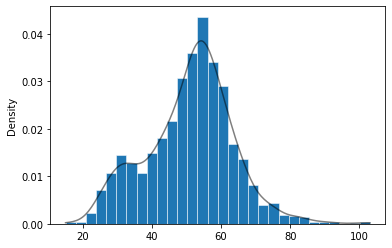

In [ ]:
import seaborn as sns
import statistics


  
ax1 = sns.histplot(div_cycles, bins=30, stat='density', alpha= 1, kde=True,
                    edgecolor='white', linewidth=0.5,
                    line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
ax1.get_lines()[0].set_color('black')
mn = statistics.mean(division_lengths)
sd = statistics.stdev(division_lengths)


print('Division lengths population')
print('mean', mn, 'sd', sd)

In [ ]:
import seaborn as sns
import statistics
  
ax1 = sns.histplot(div_cycles, bins=20, stat='density', alpha= 1, kde=True,
                    edgecolor='white', linewidth=0.5,
                    line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
ax1.get_lines()[0].set_color('black')
mn = statistics.mean(div_cycles)
sd = statistics.stdev(div_cycles)

print('div cycle lengths')
print(mn, sd)

In [ ]:

def get_colony(cells, mother_id):
  colony = []
  colony.append(mother_id)
  for cell in lin.cells:
    if cell['mother'] == mother_id or cell['mother'] in colony:
      colony.append(cell['id'])
                    
  return colony 

get_colony(lin.cells, 3)



[53, 68, 142, 173, 257, 312, 377, 383, 454, 455, 563, 564, 569, 1048, 1049, 1050, 1051, 1052, 1053, 1285, 1507, 1654]


In [ ]:
first_cells = lin.cellnumbers[0]
print(first_cells)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


In [ ]:
from matplotlib.pyplot import cm

# colony_list = {} #dict
color_list = []
colony_list = []


for idx, cell in enumerate(first_cells):
  colony_list.append((get_colony(lin.cells, idx)))
  # colony_list.append((c, (get_colony(lin.cells, idx))))
  
print(colony_list)

NameError: ignored

### Plottng bits 

In [ ]:


import numpy as np


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

get_cmap(51)

Number of labels: 52


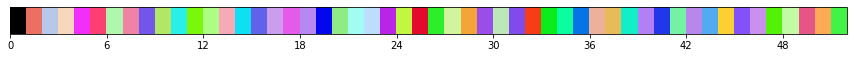

In [ ]:


def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in xrange(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

new_cmap = rand_cmap(len(colony_list), type='bright', first_color_black=True, last_color_black=False, verbose=True)

In [ ]:
rgba = [new_cmap(1)]
rgba.type()

AttributeError: ignored

## Plotting cell colonies


In [ ]:



colony_list =[]

for cell in enumerate(first_cells):
  colony_list.append((get_colony(lin.cells, cell)))
  
  # colony_list.append((c, (get_colony(lin.cells, idx))))
print(colony_list)
# c_colony = {i : [random.randrange(0,256),random.randrange(0,256),random.randrange(0,256)] for i in range(len(colony_list))}
# print(c_colony)


[[(0, 0)], [(1, 1)], [(2, 2)], [(3, 3)], [(4, 4)], [(5, 5)], [(6, 6)], [(7, 7)], [(8, 8)], [(9, 9)], [(10, 10)], [(11, 11)], [(12, 12)], [(13, 13)], [(14, 14)], [(15, 15)], [(16, 16)], [(17, 17)], [(18, 18)], [(19, 19)], [(20, 20)], [(21, 21)], [(22, 22)], [(23, 23)], [(24, 24)], [(25, 25)], [(26, 26)], [(27, 27)], [(28, 28)], [(29, 29)], [(30, 30)], [(31, 31)], [(32, 32)], [(33, 33)], [(34, 34)], [(35, 35)], [(36, 36)], [(37, 37)], [(38, 38)], [(39, 39)], [(40, 40)], [(41, 41)], [(42, 42)], [(43, 43)], [(44, 44)], [(45, 45)], [(46, 46)], [(47, 47)], [(48, 48)], [(49, 49)], [(50, 50)], [(51, 51)]]


In [ ]:

from matplotlib.lines import Line2D 

def build_legend(data):
    """
    Build a legend for matplotlib plt from dict
    """
    legend_elements = []
    for key in data:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=key,
                                        markerfacecolor=data[key], markersize=10))
    return legend_elements


NameError: ignored

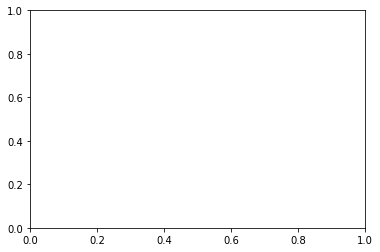

In [ ]:
fig,ax = plt.subplots(1)
ax.add_patch(rect) # Add the patch to the Axes
legend_elements = build_legend(c_colony)
ax.legend(handles=legend_elements, loc='upper left')
plt.show()

In [ ]:
def rgb_to_rgba(rgb_value, alpha):
    """
    Adds the alpha channel to an RGB Value and returns it as an RGBA Value
    :param rgb_value: Input RGB Value
    :param alpha: Alpha Value to add  in range [0,1]
    :return: RGBA Value
    """
    return f"rgba{rgb_value[3:-1]}, {alpha})"


### Plotting bits 2 - main 


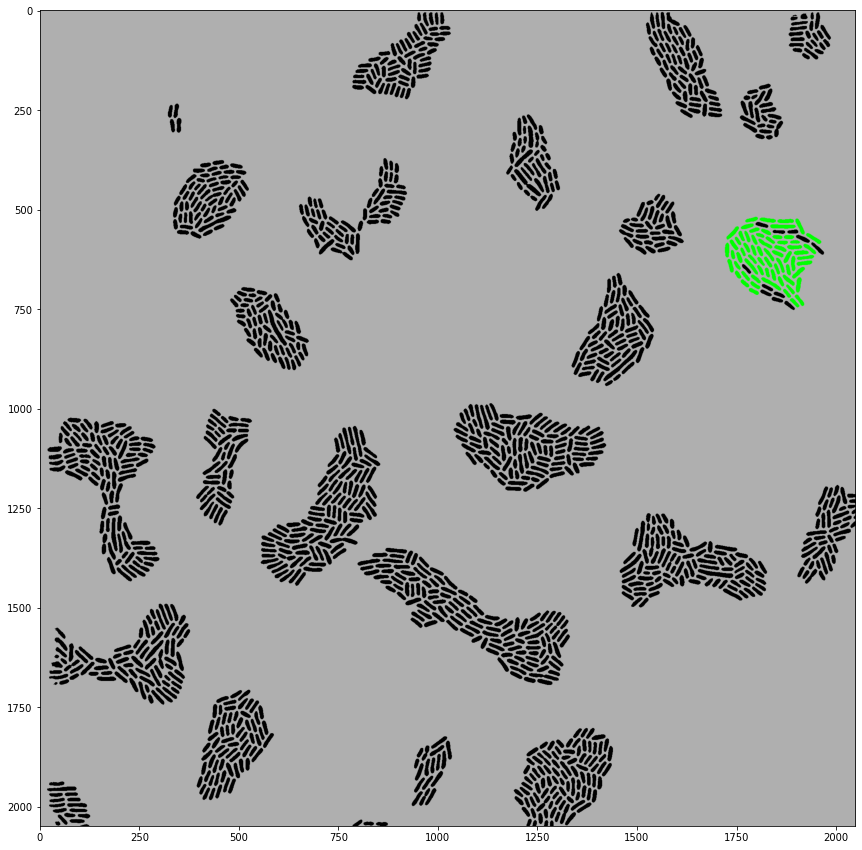

In [ ]:
import numpy as np
import matplotlib.patches as mpatches
import random
from matplotlib.lines import Line2D 

colony_10 = get_colony(lin.cells, 10)
colony_11 = get_colony(lin.cells, 11)
colony_1011 = colony_10 + colony_11
# colony2 = get_colony(lin.cells, 2)

labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

for cnb in lin.cellnumbers[-1]:
  if cnb in colony_1011:
    color = [0,255,0]
  else: 
    color = [0,0,0]


  for c, val in enumerate(color):
    color_image[:,:,c][labels==cnb+1]=val
   

plt.figure(figsize = (15,15))
plt.imshow(color_image)
# plt.legend(markers, c_colony.keys(), numpoints=1)
plt.show()


In [ ]:

import numpy as np
import matplotlib.patches as mpatches
import random
from matplotlib.lines import Line2D 

colony_list = []


for idx, cell in enumerate(first_cells):
  colony_list.append((get_colony(lin.cells, idx)))
  # colony_list.append((c, (get_colony(lin.cells, idx))))
  
print(colony_list)
 
c_colony = {i : [random.randrange(0,256),random.randrange(0,256),random.randrange(0,256)] for i in range(len(colony_list))}

print(colony_list)

colors = []
mothers =[]
# Last labels frame:
labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# color =[]
# Go over cells in last frame:
for cnb in lin.cellnumbers[-1]:
  for lst in colony_list: 
    # print(cnb)
    # print(lst)
    if cnb in lst: 
      i = colony_list.index(lst)
      color = c_colony[i]
    else: 
      coour =[0,0,0]

      for c, val in enumerate(color):
        color_image[:,:,c][labels==cnb+1]=val
   
      
    
    # Color in the cell:
    
        # print(c,val)

# colors_r =[]
# for c in colors: 
#   cn = np.array(c)
#   colors_r.append(cn)

# for c in colors: 
#   colors_rgba.append(plt.to_rgba(c))

# patches = [mpatches.Patch(color= colors[i], alpha = 0.5, label="Mother_cell".format(l=mothers[i]) ) for i in range(len(mothers)) ]
# patches = [mpatches.Patch(color=rgb_to_rgba(colors[i]), label="Mother_cell".format(l=mothers[i]) ) for i in range(len(mothers)) ]


# markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in c_colony.values()]

plt.figure(figsize = (15,15))
plt.imshow(color_image)
# plt.legend(markers, c_colony.keys(), numpoints=1)
plt.show()
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



[[0, 61, 113, 114, 248, 249, 441, 543, 544, 545, 546, 818, 1017, 1018, 1019, 1240, 1241, 1896, 2116, 2179, 2242, 2327], [1, 98, 164, 361, 363, 364, 442, 547, 684, 685, 820, 821, 826, 1020, 1021, 1022, 1023, 1244, 1466, 1469, 1471, 1478, 1622, 1626, 1627, 1640, 1642, 1772, 1773, 1774, 1777, 1897, 1900, 1902, 1903, 1904, 1906, 1908, 1909, 2014, 2022, 2112, 2121, 2180, 2181, 2182, 2243, 2286, 2325, 2326, 2366], [2, 99, 165, 200, 365, 366, 367, 444, 686, 689, 1026, 1250, 1479, 1484, 1632, 1635, 1636, 1639, 1644, 1910, 2017, 2018, 2019, 2124, 2244, 2245, 2287], [3, 84, 140, 168, 299, 301, 368, 370, 549, 688, 692, 694, 695, 696, 823, 828, 1025, 1246, 1247, 1248, 1251, 1473, 1474, 1475, 1481, 1482, 1483, 1485, 1624, 1629, 1637, 1638, 1643, 1645, 1775, 2117, 2118, 2119], [4, 83, 166, 167, 298, 300, 369, 443, 687, 690, 691, 693, 822, 829, 1242, 1243, 1245, 1249, 1252, 1467, 1470, 1480, 1621, 1625, 1628, 1641, 1776, 1779, 1898, 1899, 1905, 2011, 2021, 2024], [5, 52, 116, 117, 201, 251, 252, 253,

KeyboardInterrupt: ignored

In [ ]:
for value in c_colony: 
  if value == [255,255,0]:
    print(key)



In [ ]:
print(c_colony)


{0: [24, 142, 177], 1: [20, 43, 156], 2: [183, 149, 232], 3: [149, 190, 87], 4: [218, 180, 20], 5: [50, 37, 80], 6: [106, 224, 50], 7: [125, 62, 3], 8: [84, 190, 121], 9: [187, 171, 66], 10: [249, 235, 42], 11: [134, 114, 192], 12: [208, 143, 105], 13: [76, 53, 127], 14: [156, 98, 32], 15: [235, 146, 41], 16: [164, 152, 154], 17: [105, 205, 255], 18: [90, 223, 163], 19: [46, 223, 230], 20: [169, 45, 221], 21: [11, 131, 117], 22: [236, 117, 226], 23: [124, 217, 54], 24: [234, 3, 147], 25: [142, 161, 225], 26: [157, 76, 237], 27: [70, 5, 84], 28: [30, 14, 209], 29: [112, 19, 213], 30: [43, 242, 48], 31: [254, 226, 30], 32: [124, 103, 94], 33: [229, 38, 56], 34: [138, 80, 214], 35: [180, 187, 52], 36: [38, 10, 206], 37: [74, 146, 166], 38: [200, 14, 218], 39: [97, 198, 175], 40: [85, 241, 95], 41: [248, 125, 140], 42: [171, 146, 21], 43: [97, 124, 53], 44: [146, 200, 10], 45: [3, 122, 140], 46: [204, 117, 177], 47: [128, 217, 253], 48: [63, 69, 32], 49: [8, 151, 85], 50: [118, 129, 59], 51: [156, 16, 68]}

{0: [24, 142, 177], 1: [20, 43, 156], 2: [183, 149, 232], 3: [149, 190, 87], 4: [218, 180, 20], 5: [50, 37, 80], 6: [106, 224, 50], 7: [125, 62, 3], 8: [84, 190, 121], 9: [187, 171, 66], 10: [249, 235, 42], 11: [134, 114, 192], 12: [208, 143, 105], 13: [76, 53, 127], 14: [156, 98, 32], 15: [235, 146, 41], 16: [164, 152, 154], 17: [105, 205, 255], 18: [90, 223, 163], 19: [46, 223, 230], 20: [169, 45, 221], 21: [11, 131, 117], 22: [236, 117, 226], 23: [124, 217, 54], 24: [234, 3, 147], 25: [142, 161, 225], 26: [157, 76, 237], 27: [70, 5, 84], 28: [30, 14, 209], 29: [112, 19, 213], 30: [43, 242, 48], 31: [254, 226, 30], 32: [124, 103, 94], 33: [229, 38, 56], 34: [138, 80, 214], 35: [180, 187, 52], 36: [38, 10, 206], 37: [74, 146, 166], 38: [200, 14, 218], 39: [97, 198, 175], 40: [85, 241, 95], 41: [248, 125, 140], 42: [171, 146, 21], 43: [97, 124, 53], 44: [146, 200, 10], 45: [3, 122, 140], 46: [204, 117, 177], 47: [128, 217, 253], 48: [63, 69, 32], 49: [8, 151, 85], 50: [118, 129, 59], 5

In [ ]:
from scipy.io import loadmat

reloaded = loadmat('/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/WT_Nogm_RepBio1_RepT1_tl/eval_movie/Position000000.mat',simplify_cells=True)

In [ ]:
# Lineage of sixth chamber (index 5 in python)

lin = reloaded['res']['lineage']

# Mother cell:
mother = lin[0]

# Plot daughters fluorescence:
for daughter_nb in mother['daughters']:
    if daughter_nb > 0:
        daughter = lin[int(daughter_nb)-1] # No -1 in Matlab
        plt.plot(daughter['frames'],daughter['fluo1'],color=[.5,.5,.5])

# Plot mother fluorescence:
plt.plot(mother['frames'], mother['fluo1'])

plt.xlabel('frame #')
plt.ylabel('GFP (a.u.)')
plt.show()

KeyError: ignored

# For A_Gm_Rep1_Ph_run, loading reader and processor

In [ ]:

delta.config.load_config(presets='2D')

#these two lines might fix tracking issues: (only when actually running the pipeline)
delta.config.drift_correction = True
delta.config.whole_frame_drift = True

# # '/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_unzipped',
#  # resfolder='/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_eval_movie2/'

reader = delta.utilities.xpreader(
   '/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_unzipped',
    # prototype='Position%01d_Channel%01d_Frame%00002d.tif',
)

processor = delta.pipeline.Pipeline(
    reader,
    resfolder='/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_eval_movie2/',
    reload=True
    )

# For vsFpvA_gm_RepBio1_RepT1_tl, loading reader and processor

In [ ]:
% cd /content
% ls
% cd gdrive2
% cd MyDrive
% cd Delta2Runs
% cd vsFpvA_gm_RepBio1_RepT1_tl
% cd unzipped



In [ ]:
#Output files -> pkl file. #This works for some reason. #1st step:. 
import pickle

pos = delta.pipeline.load_position('/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/vsFpvA_gm_RepBio1_RepT1_tl/eval_movie2/Position000000.pkl')

reader = delta.utilities.xpreader('/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/vsFpvA_gm_RepBio1_RepT1_tl/unzipped')
processor = delta.pipeline.Pipeline(
    reader,
    resfolder='/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/vsFpvA_gm_RepBio1_RepT1_tl/eval_movie2/',
    reload = True

    )


In [ ]:
lin = processor.positions[0].rois[0].lineage
first_cells = lin.cellnumbers[0]

In [ ]:
# Finding all of the cells that originated from a given mother cell 
mother_id = 
colony = []
for cell in lin.cells:
  if cell['mother'] == mother_id or cell['mother'] in colony:
    colony.append(cell['id'])  


In [ ]:
import matplotlib.pyplot as plt


for cnb in colony: 
  cell = lin.cells[cnb]
  plt.plot(cell['frames'],cell['length'])
# for cell in lin.cells: 
#   plt.plot(cell['frames'],cell['length'])

plt.xlabel('frame #')
plt.ylabel('length (pixels)')
plt.show()



In [ ]:
# code to calculate crowdedness during a division event 
import math

def get_centre(npole, opole):
  cell_centre = ((npole[0] + opole[0])/2 ,  (npole[1] + opole[1])/2)
  return cell_centre

def get_cell_dist(centre1, centre2):
  # dist = ((centre1[0] + centre2[0])/2 ,  (centre1[1] + centre2[1])/2)
  dist = math.sqrt(((centre1[0] - centre2[0])**2 + (centre1[1] - centre2[1])**2))
  return dist

def get_crowd_2(cell_dist, cell_length):
  crowd = math.e**((-cell_dist/cell_length))
  return crowd


In [ ]:
def crowdedness_col(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  total_crowdedness = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  for cnb in colony: 
    cell = lin.cells[cnb]
    # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    crowdedness = 0 #assign crowdedness to zero initially 
    crowd_ids.append(cell['id'])
    # print(cell['id'])
    # print(daughters)
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        frame_no = cell['frames'][idx]
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        division_lengths.append(cell_div_length)
        for cnb2 in colony:
          cell2 = lin.cells[cnb2]
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            cell2_centre = get_centre(npole2, opole2)
            # get distance between the two centre points 
            cell_dist = get_cell_dist(cell1_centre, cell2_centre)
            crowd_pair = get_crowd_2(cell_dist, cell1_length)
            crowdedness = crowdedness + crowd_pair 
            # conditions for calculating cell cycle are different, depending if there is only one div or more
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              # print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
            div_cycle_lengths.append(div_cycle)
            total_crowdedness.append(crowdedness)

    plot = plt.scatter(total_crowdedness, div_cycle_lengths)
    plt.xlabel('Crowdedness at division time')
    plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  return plot

crowdedness_col(colony_clean)


In [ ]:
print(lin.cells[158])

In [ ]:
#  Colony clean - basically picking length curves corresponding to cells with specific maxima or minima. 
# fltering step? 

colony_clean =[]

for cnb in colony: 
  cell = lin.cells[cnb]
  if max(cell['length']) > 40 and min(cell['length']) < 23:
    colony_clean.append(cell['id'])
  
print(colony_clean)

In [ ]:

import matplotlib.pyplot as plt


for cl in colony_clean: 
  cell = lin.cells[cl]
  plt.plot(cell['frames'],cell['length'])

plt.xlabel('frame #')
plt.ylabel('length (pixels)')
plt.show()


In [ ]:
# code to calculate crowdedness during a division event 
import math

def get_centre(npole, opole):
  cell_centre = ((npole[0] + opole[0])/2 ,  (npole[1] + opole[1])/2)
  return cell_centre

def get_cell_dist(centre1, centre2):
  # dist = ((centre1[0] + centre2[0])/2 ,  (centre1[1] + centre2[1])/2)
  dist = math.sqrt(((centre1[0] - centre2[0])**2 + (centre1[1] - centre2[1])**2))
  return dist

def get_crowd_2(cell_dist, cell_length):
  crowd = math.e**((-cell_dist/cell_length))
  return crowd

  


In [ ]:
for cnb in colony: 
  cell = lin.cells[cnb]
  print(cell['id'])
  cell1_centre = get_centre(cell)
  print(cell1_centre)

In [ ]:
for cnb in colony: 
  cell = lin.cells[cnb]
  daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
  

  print(daughters)

In [ ]:

def crowdedness_col(colony):
  # record keeping for plotting later
  # cell id 
  crowd_ids = [] 
  # total crowdedness at a given timepoint, given by frame number 
  total_crowdedness = []
  # length of div cycle between two given daughters
  div_cycle_lengths= []
  division_lengths =[]
  for cnb in colony: 
    cell = lin.cells[cnb]
    # Line below: for every cell identify the occurrence of every daugther 
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    crowdedness = 0 #assign crowdedness to zero initially 
    crowd_ids.append(cell['id'])
    # print(cell['id'])
    # print(daughters)
    if len(daughters) > 0: #if the cell has divided
      for daughter in daughters: 
        #take care with definition daughter: daughter is the index position in cell in daughter list, when daughter is not none
        # this is then converted to a frame number which can be used to compare and calculate distances to other cells in the same frame
        idx= daughter-1
        frame_no = cell['frames'][idx]
        print('frame', frame_no)
        npole1 = cell['new_pole'][idx]
        opole1 = cell['old_pole'][idx]
        # get centre of cell 1 for distance function 
        cell1_centre = get_centre(npole1, opole1) 
        cell1_length = cell['length'][0] # l0 of cell, needed in the crowdedness calculation
        cell_div_length = cell['length'][idx]
        division_lengths.append(cell_div_length)
        for cnb2 in colony:
          cell2 = lin.cells[cnb2]
          if cell['id'] != cell2['id'] and frame_no in cell2['frames']:
            idx2 = cell2['frames'].index(frame_no)
            npole2 = cell2['new_pole'][idx2]
            opole2 = cell2['old_pole'][idx2]
            cell2_centre = get_centre(npole2, opole2)
            # get distance between the two centre points 
            cell_dist = get_cell_dist(cell1_centre, cell2_centre)
            crowd_pair = get_crowd_2(cell_dist, cell1_length)
            crowdedness = crowdedness + crowd_pair 
            # conditions for calculating cell cycle are different, depending if there is only one div or more
            daughter_index = daughters.index(daughter)
            if len(daughters) > 1 and daughter_index > 0:
              prev_daughter = daughters[daughter_index-1]
              print(daughter, prev_daughter)
              div_cycle = frame_no - cell['frames'][prev_daughter]
            else:
              div_cycle = frame_no - cell['frames'][0]
            div_cycle_lengths.append(div_cycle)
            total_crowdedness.append(crowdedness)

    plot = plt.scatter(total_crowdedness, div_cycle_lengths)
    plt.xlabel('Crowdedness at division time')
    plt.ylabel('Division cycle length ')
  # return crowd_ids, division_lengths, total_crowdedness, div_cycle_lengths , plot
  return plot, total_crowdedness, crowd_ids 

crowdedness_col(colony)


In [ ]:
# get length distribution of divisions for entire population 
import seaborn as sns
import statistics

def div_length_distr(cells): 
  cell_id =[]
  pop_div_lengths =[]
  for cell in cells:
    for daughter in cell['daughters']:
        if daughter is not None:
          divdot = cell['daughters'].index(daughter)
          div_l = divdot - 1 
          div_length = cell['length'][div_l]
          pop_div_lengths.append(div_length)
  ax1 = sns.histplot(pop_div_lengths, bins=30, stat='density', alpha= 1, kde=True,
                      edgecolor='white', linewidth=0.5,
                      line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
  ax1.get_lines()[0].set_color('black')
  mn = statistics.mean(pop_div_lengths)
  sd = statistics.stdev(pop_div_lengths)

  return ax1 , mn, sd

div_length_distr(lin.cells)



In [ ]:
def div_time_distr(cells): 
  cell_id =[]
  pop_div_times =[]
  for cell in cells:
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    for daughter in daughters: 
      daughter_index = daughters.index(daughter)
      if len(daughters) > 1 and daughter_index > 0:
        prev_daughter = daughters[daughter_index-1]
        div_cycle = cell['frames'][daughter] - cell['frames'][prev_daughter]
      else:
        div_cycle =  cell['frames'][daughter] - cell['frames'][0]
      cell_id.append(cell['id'])
      pop_div_times.append(div_cycle)
    
    ax1 = sns.histplot(pop_div_times, bins=100, stat='density', alpha= 1, kde=True,
                      edgecolor='white', linewidth=0.5,
                      line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
  ax1.get_lines()[0].set_color('black')
  mn = statistics.mean(pop_div_times)
  sd = statistics.stdev(pop_div_times)

  return ax1 , mn, sd 

div_time_distr(lin.cells)



In [ ]:
def div_time_distr_colony(colony): 
  cell_id =[]
  pop_div_times =[]
  for cnb in colony: 
    cell = lin.cells[cnb]
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    for daughter in daughters: 
      daughter_index = daughters.index(daughter)
      if len(daughters) > 1 and daughter_index > 0:
        prev_daughter = daughters[daughter_index-1]
        div_cycle = cell['frames'][daughter] - cell['frames'][prev_daughter]
      else:
        div_cycle =  cell['frames'][daughter] - cell['frames'][0]
      cell_id.append(cell['id'])
      pop_div_times.append(div_cycle)
    
    ax1 = sns.histplot(pop_div_times, bins=100, stat='density', alpha= 1, kde=True,
                      edgecolor='white', linewidth=0.5,
                      line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
  ax1.get_lines()[0].set_color('black')
  mn = statistics.mean(pop_div_times)
  sd = statistics.stdev(pop_div_times)

  return ax1 , mn, sd 

div_time_distr_colony(colony)

In [ ]:
def div_time_scatter(cells): 
  cell_id =[]
  pop_div_times =[]
  for cell in cells:
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    for daughter in daughters: 
      daughter_index = daughters.index(daughter)
      if len(daughters) > 1 and daughter_index > 0:
        prev_daughter = daughters[daughter_index-1]
        div_cycle = cell['frames'][daughter] - cell['frames'][prev_daughter]
      else:
        div_cycle =  cell['frames'][daughter] - cell['frames'][0]
      cell_id.append(cell['id'])
      pop_div_times.append(div_cycle)
    
    plot = plt.scatter(cell_id, pop_div_times)
  return plot

div_time_scatter(lin.cells)

## Identifying and plotting slow and fast dividers on real colony data 

In [ ]:

def how_crowded(total_crowdedness, crowd_ids):
  for i in total_crowdedness: 
    if i > 4: 
      crowd_ids[i]
      


In [ ]:

def how_crowded(total_crowdedness, crowd_ids):
  for i in total_crowdedness: 
    if i > 4: 
      


def which_first(lineage, cell_nb, first_cells):

    # Get cell dict:
    cell = lineage.cells[cell_nb]

    # If orphan or reached one of the first two cells:
    if cell['mother'] is None or cell['mother'] in first_cells:
        return cell['mother']

    # Otherwise go up the lineage tree:
    else:
        return which_first(lineage, cell['mother'], first_cells)

import numpy as np

# Last labels frame:
labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# Go over cells in last frame:
for cnb in lin.cellnumbers[-1]:

    # Which initial cell is ancestor?
    ancestor = which_first(lin, cnb, first_cells)

    # Pick color based on ancestor:
    if ancestor is None:
        if cnb==0:
            color=[255,0,0]
        elif cnb==1:
            color=[0,0,255]
        else:
            color=[0,0,0]
    elif ancestor==0:
        color=[200,60,60]
    elif ancestor==1:
        color=[60,60,200]

    # Color in the cell:
    for c, val in enumerate(color):
        color_image[:,:,c][labels==cnb+1]=val

plt.imshow(color_image)
plt.show()

Cells with good plots for further analysis: 

Cell number 1, 



In [ ]:
pop_div_lengths = []

for cell in lin.cells:
  if cell['id'] in do7: 
    for daughter in cell['daughters']:
      if daughter is not None:
        divdot = cell['daughters'].index(daughter)
        div_l = divdot - 1 
        div_length = cell['length'][div_l]
        pop_div_lengths.append(div_length)
    plt.scatter(cell['id'], div_length)
    plt.xlabel('cell_id')
    plt.ylabel('div_length')




In [ ]:
pop_div_cycle = []

for cell in lin.cells:
  for daughter in cell['daughters']:
    if daughter is not None:
      divdot = cell['daughters'].index(daughter)
      div_time = divdot - 1 
      div_cycle = len(cell['daughters'][0:div_time])
      pop_div_cycle.append(div_cycle)
  plt.scatter(cell['id'], div_cycle)
  plt.xlabel('cell_id')
  plt.ylabel('div_cycle_length(# frames)')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [ ]:
# DIVISION TIME

ax1 = sns.histplot(pop_div_cycle, bins=30, stat='density', alpha= 1, kde=True,
                  edgecolor='white', linewidth=0.5,
                  line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
ax1.get_lines()[0].set_color('black')


In [ ]:
# DIVISION LENGTH (in pixels)

ax1 = sns.histplot(pop_div_lengths, bins=30, stat='density', alpha= 1, kde=True,
                  edgecolor='white', linewidth=0.5,
                  line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='KDE'))
ax1.get_lines()[0].set_color('black')



In [ ]:
(sum(pop_div_lengths))/(len(pop))

In [ ]:
import numpy as np

# Last labels frame:
labels = processor.positions[0].rois[0].label_stack[-1]

do7 = []
for cell in lin.cells:
  if cell['mother'] == 1:
    do7.append(cell['id'])
  if cell['mother'] in do7:
    do7.append(cell['id'])
  
       
print(len(do7))

# Last labels frame:
labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )


for cnb in lin.cellnumbers[-1]:
  if cnb in do7:
    color=[60,60,200]
  else: 
    color =[255,0,0]

for c, val in enumerate(color):
      color_image[:,:,c][labels==cnb+1]=val

plt.imshow(color_image)
plt.show()






In [ ]:
def which_first(lineage, cell_nb, first_cells):

    # Get cell dict:
    cell = lineage.cells[cell_nb]

    # If orphan or reached one of the first two cells:
    if cell['mother'] is None or cell['mother'] in first_cells:
        return cell['mother']

    # Otherwise go up the lineage tree:
    else:
        return which_first(lineage, cell['mother'], first_cells)


import numpy as np

# Last labels frame:
labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# Go over cells in last frame:
for cnb in lin.cellnumbers[-1]:

    # Which initial cell is ancestor?

    # Pick color based on ancestor:
    if ancestor is None:
        if cnb==0:
            color=[255,0,0]
        
        color=[60,60,200]

    # Color in the cell:
    for c, val in enumerate(color):
        color_image[:,:,c][labels==cnb+1]=val

plt.imshow(color_image)
plt.show()

In [ ]:

def which_first(lineage, cell_nb, first_cells):

    # Get cell dict:
    cell = lineage.cells[cell_nb]

    # If orphan or reached one of the first two cells:
    if cell['mother'] is None or cell['mother'] in first_cells:
        return cell['mother']

    # Otherwise go up the lineage tree:
    else:
        return which_first(lineage, cell['mother'], first_cells)

In [ ]:
cell = lineage.cells[cell_nb]

In [ ]:
pos = delta.pipeline.Position(None,None,None)
pos.load('/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/eval_movie_A_Gm_Rep1/Position000000.pkl')

# pos = delta.pipeline.load_position('/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/eval_movie_A_Gm_Rep1/Position000000.pkl')

In [ ]:
lin = processor.positions[0].rois[0].lineage

In [ ]:
reader = delta.utilities.xpreader(delta.config.eval_movie)
processor = delta.pipeline.Pipeline(reader, reload=True)

In [ ]:
file = 'gdrive/MyDrive/A_Gm_Rep1_Ph_run/eval_movie_A_Gm_rep1/Position000000.mat'
file


## **Running a pipeline : see cell below**


In [ ]:
# this is to run a pipeline 

import shutil
import glob
import os

#Possible way to automate
#files = os.listdir(directory name here)
#stem = directory name here
#for f in files:
  #f = stem + f
  # do something



# Load the appropriate config:
delta.config.load_config(presets='2D')

#these two lines might fix tracking issues:
delta.config.drift_correction = True
delta.config.whole_frame_drift = True

# Path to your file and results folder in your google drive:
filename = '/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1.zip'
results_folder = '/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_eval_movie2/' 


# Extract zip"
extract_folder = '/A_Gm_Rep1_Ph_run/unzipped2'
shutil.unpack_archive(filename, extract_folder, "zip")

# Init:
reader = delta.utilities.xpreader(extract_folder)
sequence_ppln = delta.pipeline.Pipeline(reader, resfolder='./local_results/')

# Run:
sequence_ppln.process()

# copy output files to drive:
for res_file in glob.glob(str(sequence_ppln.resfolder)+ '/*'):
    shutil.copy(res_file, results_folder)


Extra imports and misc function definitions:

In [ ]:
# To download files to your local drive:
from google.colab.files import download as colab_download
from google.colab.files import upload as colab_upload

# To display resuults movies:
from IPython.display import HTML
from base64 import b64encode

def display_movie(filename):
  mp4 = open(filename,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=600 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url
  )

# Process sequence folder:

Here we will use the private function _download_and_unzip() to retrieve a zipped
image sequence folder, read it with an xpreader object, and process it with the main DeLTA Pipeline:

> *The following example will take about 20 minutes to run. For a shorter demonstration comment ppln.process() and uncomment the last line*

In [ ]:
# First load 2D config:
delta.config.load_config(presets='2D')

# Download movie sequence (you can replace this with your own zip's ID)
google_drive_ID = '1PpAGwKF5nQnVmwYg2ww5fXPLMLZecah_' # This can be extracted from the URL of any publically available gdrive file
temporary_zip = '/content/tmp.zip'
extract_folder = '/content/eval_movie_folder/'
delta.assets._download_and_unzip(
    google_drive_ID,
    temporary_zip,
    extract_folder
)

# Init xpreader:
# (make sure you update prototype parameters if you use your own movie)
reader = delta.utilities.xpreader(
    extract_folder,
    prototype='movie_tifs/pos%01dcha%01dfra%06d.tif',
    fileorder='pct',
    filenamesindexing=1
)

# Print experiment parameters to make sure it initialized properly:
print("""Initialized experiment reader:
    - %d positions
    - %d imaging channels
    - %d timepoints"""%(reader.positions, reader.channels, reader.timepoints)
)

# Init Pipeline:
ppln = delta.pipeline.Pipeline(reader)

# Run it (~20 min):
ppln.process()

# Or you can run a subset of frames (5min):
#ppln.process(frames=list(range(15)))

In [ ]:
# Display output movie:
display_movie(ppln.resfolder / "Position000000.mp4")

In [ ]:
# Download result files to your own computer:
colab_download(ppln.resfolder / 'Position000000.mat')

# Process Bio-Formats file:

Here we will process a subset of positions on an nd2 file of a mother machine movie.

In [ ]:
# First load mothermachine config:
delta.config.load_config(presets='mothermachine')

# Download movie sequence (you can replace this with your own file's ID)
google_drive_ID = '1YEvhkNB2lWOGFAuG1bmV7ZcwFE1FiDaR' # This can be extracted from the URL of any publically available gdrive file
filename = '/content/eval_movie_moma.nd2'
delta.assets._download_file_from_google_drive(
    google_drive_ID,
    filename
)

# Init xpreader:
reader = delta.utilities.xpreader(
    filename,
    use_bioformats=True
)

# Print experiment parameters to make sure it initialized properly:
print("""Initialized experiment reader:
    - %d positions
    - %d imaging channels
    - %d timepoints"""%(reader.positions, reader.channels, reader.timepoints)
)

# Init Pipeline:
ppln = delta.pipeline.Pipeline(reader)

# Run it (~20 min):
ppln.process(positions=[2,3,5])

In [ ]:
# Display output movie:
display_movie(ppln.resfolder / 'Position000003.mp4')

In [ ]:
# Zip all results and download:
from zipfile import ZipFile
import glob

with ZipFile('results_files.zip', 'w') as myzip:
    for res_file in glob.glob(str(ppln.resfolder) + '/*'):
        print('zipping %s'%res_file)
        myzip.write(res_file)

colab_download('results_files.zip')

# Process file from your google drive directly

Here is an example of how you can mount your own google drive, process a file in there (or potentially several), and directly get your results back in your google drive when they are ready. Before executing 
this cell, please mount your google drive through the files tab on the left

In [ ]:
import shutil
import glob

# Load the appropriate config:
delta.config.load_config(presets='2D')

# Mount path:
drive_path = '/content/drive/MyDrive'

# Path to your file and results folder in your google drive:
filename = '/path/to/file/in/my/drive.nd2'
results_folder = '/path/to/results/folder/in/drive/' # This folder must exist

# copy file to local disk to avoid i/o problems:
local_file = "/content/local_file_copy.nd2"
shutil.copy(drive_path+filename, local_file)



# Init:
reader = delta.utilities.xpreader(local_file, use_bioformats=True)
sequence_ppln = delta.pipeline.Pipeline(reader, resfolder='./local_results/')

# Run:
sequence_ppln.process(positions=[0,1], frames=list(range(30)))

# copy output files to drive:
for res_file in glob.glob(str(sequence_ppln.resfolder) + '/*'):
    shutil.copy(res_file, drive_path+results_folder)

# Training new models

You can download training sets and run our modified training
scripts as well. However bear in mind that you might run into google Colab's resource limits

Here, we are going to show an example to retrain the segmentation model for the 2D case

First, download our segmentation training set (or your own training set if you made one):

In [ ]:
# Download movie sequence (you can replace this with your own zip's ID)
google_drive_ID = '1sWWkIDjIf77KwddHZgX64f8_LxV7hQx_' # This can be extracted from the URL of any publically available gdrive file
temporary_zip = '/content/tmp.zip'
extract_folder = '/content/trainging_set/'
delta.assets._download_and_unzip(
    google_drive_ID,
    temporary_zip,
    extract_folder
)

We then copy the example segmentation training script from the
gitlab and simply change the training set path:

In [ ]:
import os

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from delta.utilities import cfg
from delta.model import unet_seg
from delta.data import trainGenerator_seg

# Load config:
cfg.load_config(presets='2D')

# Files:
# Point to extracted folder:
training_set = extract_folder+'/training/segmentation_set'
# Overwrite seg model:
savefile = cfg.model_file_seg

# Training parameters:
batch_size = 4
epochs = 600
steps_per_epoch = 300
patience = 50

#Data generator parameters:
data_gen_args = dict(
    rotation = 2,
    rotations_90d = True,
    zoom=.15,
    horizontal_flip=True,
    vertical_flip=True,
    histogram_voodoo=True,
    illumination_voodoo=True,
    gaussian_noise = 0.03,
    gaussian_blur = 1
    )

# Generator init:
myGene = trainGenerator_seg(
    batch_size,
    os.path.join(training_set,'img'),
    os.path.join(training_set,'seg'),
    os.path.join(training_set,'wei'),
    augment_params = data_gen_args,
    target_size = cfg.target_size_seg,
    crop_windows = cfg.crop_windows
    )

# Define model:
model = unet_seg(input_size = cfg.target_size_seg+(1,))
model.summary()

# Callbacks:
model_checkpoint = ModelCheckpoint(
    savefile, monitor='loss', verbose=2, save_best_only=True
    )
early_stopping = EarlyStopping(
    monitor='loss', mode='min', verbose=2, patience=patience
    )

# Train:
history = model.fit(
    myGene,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[model_checkpoint, early_stopping]
    )


You can now evaluate performance by using one of the methods described above, or run a simple segmentation prediction on our test data:


In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython import display

files_folder = '/content/delta/tests/data/movie_tif/'
images = glob.glob(files_folder+'/*.tif')
images.sort()

# Load weights from file:
model.load_weights(savefile)

for filename in images:
    
    # Read image:
    I = cv2.imread(filename, cv2.IMREAD_ANYDEPTH)
    # Rescale to 0-1:
    I = (I.astype(np.float32)-np.min(I))/np.ptp(I)
    # Run prediction:
    y = model.predict(I[np.newaxis,:,:,np.newaxis])
    # Display output:
    plt.imshow(y[0,:,:,0])
    display.display(plt.gcf())
    display.clear_output(wait=True)